<a href="https://colab.research.google.com/github/auroramugnai/Minimum-Exact-Cover-Problem/blob/main/MECP_with-QAOA/QAOA_random_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the MECP with QAOA+ using "Random Parameters" technique

In [6]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/auroramugnai/Minimum-Exact-Cover-Problem.git
%cd Minimum-Exact-Cover-Problem/MECP_with-QAOA
!pip install -r requirements.txt

fatal: destination path 'Minimum-Exact-Cover-Problem' already exists and is not an empty directory.
/content/Minimum-Exact-Cover-Problem/MECP_with-QAOA
 gaps.ipynb
 k_analysis.ipynb
 multiple_barplot.ipynb
'parameter_fixing_2025-01-30@10h22m24s'/
 QAOA_parameter_fixing.ipynb
 QAOA_random_parameters.ipynb
 random_instances.py
'random_parameters_2025-01-30@09h03m50s'/
'random_parameters_2025-06-09@16h44m34s'/
'random_parameters_2025-06-09@16h52m58s'/
'random_parameters_2025-06-09@16h57m20s'/
'random_parameters_2025-06-12@10h20m27s'/
'random_parameters_2025-06-20@11h14m30s'/
'random_parameters_2025-06-20@12h00m17s'/
'random_parameters_2025-06-20@13h48m29s'/
'random_parameters_2025-06-20@14h52m53s'/
'random_parameters_2025-06-20@16h32m58s'/
'random_parameters_2025-06-20@17h27m36s'/
'random_parameters_2025-06-20@18h33m26s'/
'random_parameters_2025-07-21@17h20m50s'/
'random_parameters_2025-07-22@15h10m16s'/
'random_parameters_2025-07-23@10h37m20s'/
 README.md
 requirements.txt
 utils_for_plo

## Import Modules & Define Functions

In [8]:
from __future__ import annotations
from utils_to_build_QAOAAnsatz import *

In [9]:
from datetime import datetime
import math
import random
import time

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from scipy.optimize import minimize
from pprint import pprint # to print dictionaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [11]:
def write_params_on_file(DATA_FILE, params):

    DATA_FILE.write("\nChosen parameters:\n")
    DATA_FILE.write(f"Number of layers (p): {params['p']}\n")
    DATA_FILE.write(f"Number of random attempts: {params['random_attempts']}\n")
    DATA_FILE.write(f"Initialization type: {params['init_string']}\n")
    DATA_FILE.write(f"Size (n): {params['n']}\n")
    DATA_FILE.write(f"Chosen instances (chosen_instances): {params['chosen_instances']}\n")
    DATA_FILE.write(f"Choices of k (chosen_ks): {params['chosen_ks']}\n")


    # Display the chosen parameters
    print(f"######### ...Writing on file...: #########")
    print("Chosen parameters:")
    print(f"Number of layers (p): {params['p']}")
    print(f"Number of random attempts: {params['random_attempts']}")
    print(f"Initialization type: {params['init_string']}")
    print(f"Size (n): {params['n']}")
    print(f"Chosen instances (chosen_instances): {params['chosen_instances']}")
    print(f"Choice of ks (chosen_ks): {params['chosen_ks']}")
    print(f"##########################################")

def compute_L_EC(info_dim6):
    """ For each instance, compute the number of ones in each exact cover string
    that is not the mec string."""
    L_ECs = []
    for key in info_dim6:
        if key != 'U':
            ec_strings = info_dim6[key]['exact_covers']
            mec_string = info_dim6[key]['mec']
            for ec in ec_strings:
                if ec != mec_string:
                    L_ECs.append(ec.count('1'))
    print("L_ECs:", L_ECs)
    return L_ECs

def compute_L_MEC(info_dim6):
    """ For each instance, compute the number of ones in the mec string."""
    L_MECs = []
    for key in info_dim6:
        if key != 'U':
            mec_string = info_dim6[key]['mec']
            L_MECs.append(mec_string.count('1'))
    print("L_MECs:", L_MECs)
    return L_MECs

def compute_L_from_k(info_dim6, k):
    """ Compute L from k, where k is a parameter that we choose.
    k = L/(min_length * n) so L = k * min_length * n
    where min_length is the minimum number of elements in a subset of an instance
    and n is the number of subsets in the instance.
    Parameters
    ----------
    k : float
        The parameter k.
    info_dim6 : dict
        The dictionary containing the instances information.
    Returns
    -------
    Ls : list
        A list of L values computed from k for each instance.
    """
    n = 6
    Ls = []
    for instance in info_dim6.keys():
        if instance == 'U':
            continue
        min_length = min(len(s) for s in info_dim6[instance]['subsets'])
        Ls.append(int(k * min_length * n))

    print(f"Ls from k={k}:", Ls)



In [12]:
from random_instances import info_dim6
compute_L_EC(info_dim6)
compute_L_MEC(info_dim6)
compute_L_from_k(info_dim6, 1)

L_ECs: [3, 4, 4, 3, 4, 3, 4, 3, 4, 3]
L_MECs: [2, 3, 3, 2, 3, 2, 3, 2, 3, 2]
Ls from k=1: [12, 12, 12, 12, 12, 18, 12, 18, 12, 18]


## Set Parameters

In [13]:
### Get parameters from the user
params = get_parameters_from_user()

# Get the parameters separately
chosen_instances = params['chosen_instances']
chosen_ks = params['chosen_ks']
p = params['p']
random_attempts = params['random_attempts']
init_string = params['init_string']

n = params['n']

Number of layers (p), default is 4: 
Number of random attempts, default is 50: 
String initialization (all1 or all0), default is all0: 
Size n (6, 8, 10), default is 6: 
Chosen instances, default is [1, ..., 10] (Give a list please!): [1,2,3,4,5,6,7,8,9,10]
Choice for L, to compute k as L/(min_length * n). Give a list specifying L for every instance chosen please.[12, 12, 12, 12, 12, 18, 12, 18, 12, 18]


## For Every Instance Chosen, Do the Minimization
This code iterates through selected instances, generating corresponding subsets and computing the spectrum of states, including Minimum Exact Cover (MEC) states. It then builds the quantum circuits for the QAOA+ algorithm, including cost, mixing, and initialization circuits. Initial angles (betas and gammas) are randomly set within specified bounds, and the QAOA+ algorithm is run for multiple random initializations to minimize energy. Results, such as the optimal parameters, best attempt, minimum energy, and elapsed time, are recorded. Final data of each instance is saved in a .csv and a .txt.



Saving in folder_path = random_parameters_2025-09-10@08h23m37s
1.0 1
**************************************************
Instance 1 with h = 1.0

U, subsets, EXACT_COVERS, MEC {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} [{1, 3, 4, 5, 6, 7, 8, 9, 11, 12}, {2, 11, 4, 5}, {1, 2, 4, 5, 6, 11}, {3, 7, 8, 9, 10, 12}, {2, 3, 4, 6, 7, 8, 9, 10, 11, 12}, {1, 6}] ['001100', '010101'] ['001100']


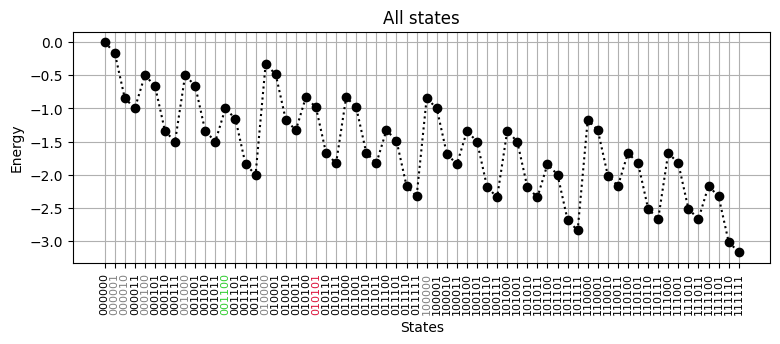

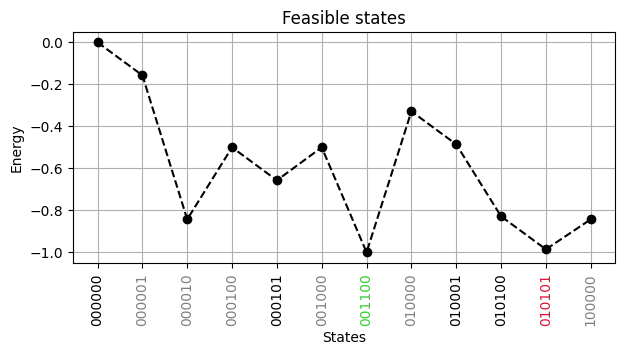

Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {1, 3, 4, 5, 6, 7, 8, 9, 11, 12}
  2: {2, 11, 4, 5}
  3: {1, 2, 4, 5, 6, 11}
  4: {3, 7, 8, 9, 10, 12}
  5: {2, 3, 4, 6, 7, 8, 9, 10, 11, 12}
  6: {1, 6}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
A = 1.6285714285714286
B = 0.04285714285714286
constant = -A + B = -1.5857142857142856

hamiltonian:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII'],
              coeffs=[0.42142857+0.j, 0.16428571+0.j, 0.25      +0.j, 0.25      +0.j,
 0.42142857+0.j, 0.07857143+0.j])
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {1, 3, 4, 5, 6, 7, 8, 9, 11, 12}
  2: {2, 11, 4, 5}
  3: {1, 2, 4, 5, 6, 11}
  4: {3, 7, 8, 9, 10, 12}
  5: {2, 3, 4, 6, 7, 8, 9, 10, 11, 12}
  6: {1, 6}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
Mixing circuit created for instance 1 with 6 qubits.
Circuit dimension (QC_DIM): 10
Number of ancillas: 4
Number of control gates: 5
Universe: {1, 2, 3, 4, 5, 6, 7, 8

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8558107040195522
E_min = result.fun = 0.7299035816947335

Optimal parameters: betas, gammas = [np.float64(6.283185299878635), np.float64(2.256073340066864), np.float64(5.980322543992022), np.float64(0.29144571263112895)], [np.float64(-9.995911534361298), np.float64(-5.839005732533426), np.float64(7.560440035016212), np.float64(3.757852400511621)]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_1of50
8  100000              813
7  010101              113
6  010100               39
3  001100               34
1  000101                9
0  000100                6
2  001000                5
5  010001                4
4  010000                1

---------- 2/50 random_attempts -----------

pars_0 = [2.0858904451651403, 5.630136174789003, 5.799048078568609, 2.580123714989834, 2.859163418841801, 7.908090742169787, 7.541501367545674, 1.0828772795341575]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.2831853071795

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8556658271952202
E_min = result.fun = 0.7300484585190654

Optimal parameters: betas, gammas = [np.float64(0.14201332146375867), np.float64(6.283185273566993), np.float64(2.3514786367355773), np.float64(0.01035256390473244)], [np.float64(9.995976625058432), np.float64(-3.4607361630345856), np.float64(-9.989634582642097), np.float64(9.995770992252162)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_3of50
8  100000              826
7  010101              136
6  010100               23
3  001100               22
5  010001                6
0  000001                5
2  001000                3
1  000101                2
4  010000                1

---------- 4/50 random_attempts -----------

pars_0 = [3.721219924008395, 3.6094690260011104, 2.649317195354367, 1.3681542234126582, 6.3208450124988005, 7.124518521959192, -3.921503088694485, 3.800531054362393]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9856614097302897
E_min = result.fun = 0.6000528759839959

Optimal parameters: betas, gammas = [np.float64(3.1233699124821346), np.float64(3.1424984760287797), np.float64(5.6947843360791435), np.float64(0.5875076913125994)], [np.float64(-2.2548453806881605), np.float64(5.473650518842158), np.float64(7.518586777939073), np.float64(-0.0055688692813697475)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_5of50
0  010101             1024

---------- 6/50 random_attempts -----------

pars_0 = [2.815950541968264, 2.1701285797381025, 4.7726534693594145, 2.330809120031571, -9.490298851314126, 3.885489218269253, 9.283056329026223, 3.8136906319894734]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfu

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9857142783973474
E_min = result.fun = 0.6000000073169383

Optimal parameters: betas, gammas = [np.float64(3.141685347816148), np.float64(3.1415847758032664), np.float64(6.0484571679395085), np.float64(0.2347534069916386)], [np.float64(-5.024586517815736), np.float64(6.057700142923356), np.float64(-2.0345145964055362), np.float64(-0.00014511389836699182)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_8of50
0  010101             1024

---------- 9/50 random_attempts -----------

pars_0 = [4.4004994899775465, 5.568414504684361, 4.170567876620533, 5.2543422373175455, -1.2620871409505732, 2.1280690675403715, 8.615559127224259, -8.636824012353905]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9256386705986459
E_min = result.fun = 0.6600756151156397

Optimal parameters: betas, gammas = [np.float64(5.457306999647086), np.float64(5.392237365157948), np.float64(4.067371691551922), np.float64(5.853912802629158)], [np.float64(1.378896642923213), np.float64(9.07219929792279), np.float64(2.5530145792168177), np.float64(-9.983399930288044)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_9of50
6   001100              655
10  100000              128
8   010100               99
9   010101               73
5   001000               29
3   000100               18
1   000001               15
4   000101                3
0   000000                2
2   000010                1
7   010001                1

---------- 10/50 random_attempts -----------

pars_0 = [5.451928704167824, 2.399536392378766, 2.9912018528542195, 1.7583128045007101, 6.469728666072669, -1.773324299215508, -7.8268193558160375, -8.177097675326939]
bnds = [(0, 6.2831853071795

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9857142857142854
E_min = result.fun = 0.6000000000000002

Optimal parameters: betas, gammas = [np.float64(3.1415926603606525), np.float64(3.141592596662477), np.float64(6.248641577829974), np.float64(0.03454375523926716)], [np.float64(6.034535037969565), np.float64(-9.804467693205268), np.float64(0.8244134651036295), np.float64(-2.9313702751328726e-06)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_15of50
0  010101              1024

---------- 16/50 random_attempts -----------

pars_0 = [1.8806975414319236, 0.8401007614607177, 0.9634772215594852, 2.1793743560187844, -3.539025755698959, -9.008944867514971, -2.450876747178933, 9.214001015721859]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated suc

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8794707156563152
E_min = result.fun = 0.7062435700579704

Optimal parameters: betas, gammas = [np.float64(3.931722108087566), np.float64(3.1525646839567827), np.float64(2.6883530635381465), np.float64(3.9429816866875917)], [np.float64(6.239030700991616), np.float64(9.995767784223368), np.float64(-9.995176481987933), np.float64(-5.725581531523517)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_20of50
10  100000               502
9   010101               341
6   001100                70
8   010100                51
3   000100                18
7   010000                14
2   000010                11
4   000101                10
5   001000                 4
1   000001                 2
0   000000                 1

---------- 21/50 random_attempts -----------

pars_0 = [5.72382557787162, 5.260580400837208, 0.8251483682663968, 4.5162988983732415, -1.606978173693273, 6.14632062665904, -4.082932468854409, 4.26194749940821]
bnds = [(0, 6.28

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8838388293869428
E_min = result.fun = 0.7018754563273428

Optimal parameters: betas, gammas = [np.float64(2.561203364001897), np.float64(3.143409372071541), np.float64(3.5419324914601558), np.float64(3.9257452265351755)], [np.float64(-9.92479018744233), np.float64(-4.844760200459911), np.float64(-9.995931881913815), np.float64(0.4448069258206305)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_24of50
9  100000               557
8  010101               398
7  010100                29
6  010001                13
4  001100                 7
3  001000                 6
5  010000                 5
0  000001                 5
1  000100                 3
2  000101                 1

---------- 25/50 random_attempts -----------

pars_0 = [3.462699690988384, 1.2413914883444312, 2.3429560030025374, 0.3849353014591812, -9.704119665676679, -2.4529268068124974, 8.967027503553783, -5.913672543135815]
bnds = [(0, 6.283185307179586), (0, 6.283185307179

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8578862182167428
E_min = result.fun = 0.7278280674975428

Optimal parameters: betas, gammas = [np.float64(0.0026369618794340483), np.float64(6.079908817465853), np.float64(6.28318528652888), np.float64(3.923839511307941)], [np.float64(-9.987974745881935), np.float64(9.995976625058432), np.float64(1.9718641703592636), np.float64(9.995976625058432)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_27of50
9  100000               784
8  010101               113
4  001100                74
7  010100                33
0  000001                10
6  010001                 5
2  000100                 2
1  000010                 1
5  010000                 1
3  000101                 1

---------- 28/50 random_attempts -----------

pars_0 = [3.5677496292330946, 0.16204450805537074, 5.8055670329556195, 4.257730429658168, -2.9219424455651435, 6.210535457404852, 8.273245585529882, -7.112047038431461]
bnds = [(0, 6.283185307179586), (0, 6.283185307179

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8535878875699587
E_min = result.fun = 0.7321263981443269

Optimal parameters: betas, gammas = [np.float64(6.2831853068792665), np.float64(2.349335180724901), np.float64(5.973843854547795), np.float64(5.9653760640576845)], [np.float64(4.593987030424466), np.float64(-9.995976625058432), np.float64(-8.734278192820469), np.float64(-7.5432865860313605)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_30of50
6  100000               869
5  010101               104
2  001100                17
3  010001                17
4  010100                11
1  001000                 5
0  000101                 1

---------- 31/50 random_attempts -----------

pars_0 = [5.19288858508696, 3.5744960358456295, 0.5333466070188583, 2.7437505780081337, 8.60351460520781, 0.12902396605541, -5.0255288091692325, -8.667851757038072]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.9959766250

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9857142857142639
E_min = result.fun = 0.6000000000000217

Optimal parameters: betas, gammas = [np.float64(3.141592640139719), np.float64(3.1415923666999754), np.float64(6.230890501222607), np.float64(0.05229496298761813)], [np.float64(9.995976625058432), np.float64(-0.7536295438616508), np.float64(0.4277910778537227), np.float64(2.751153932124657e-06)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_32of50
0  010101              1024

---------- 33/50 random_attempts -----------

pars_0 = [2.174588656332894, 2.711762399553662, 3.6097541518499066, 5.637471216668904, -9.316370429997383, -1.0081909497963562, -9.080097758137114, 0.2179620908366502]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated succe

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.918953345706126
E_min = result.fun = 0.6667609400081597

Optimal parameters: betas, gammas = [np.float64(1.9297222826420815), np.float64(5.430362067850187), np.float64(2.653657396932866), np.float64(6.283185306986417)], [np.float64(5.250384294825114), np.float64(2.0551556547399136e-05), np.float64(-2.6669760607901293e-06), np.float64(-9.983248038650942)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_47of50
3  001100               396
7  010101               277
6  010100               269
1  000010                44
4  010000                20
5  010001                13
2  000100                 3
0  000000                 2

---------- 48/50 random_attempts -----------

pars_0 = [4.10143151062411, 5.925400282880386, 3.8566576054080084, 3.3159195042549916, -2.340019566584755, -7.765991855275132, 3.9652229952236535, -4.27751599111171]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586)

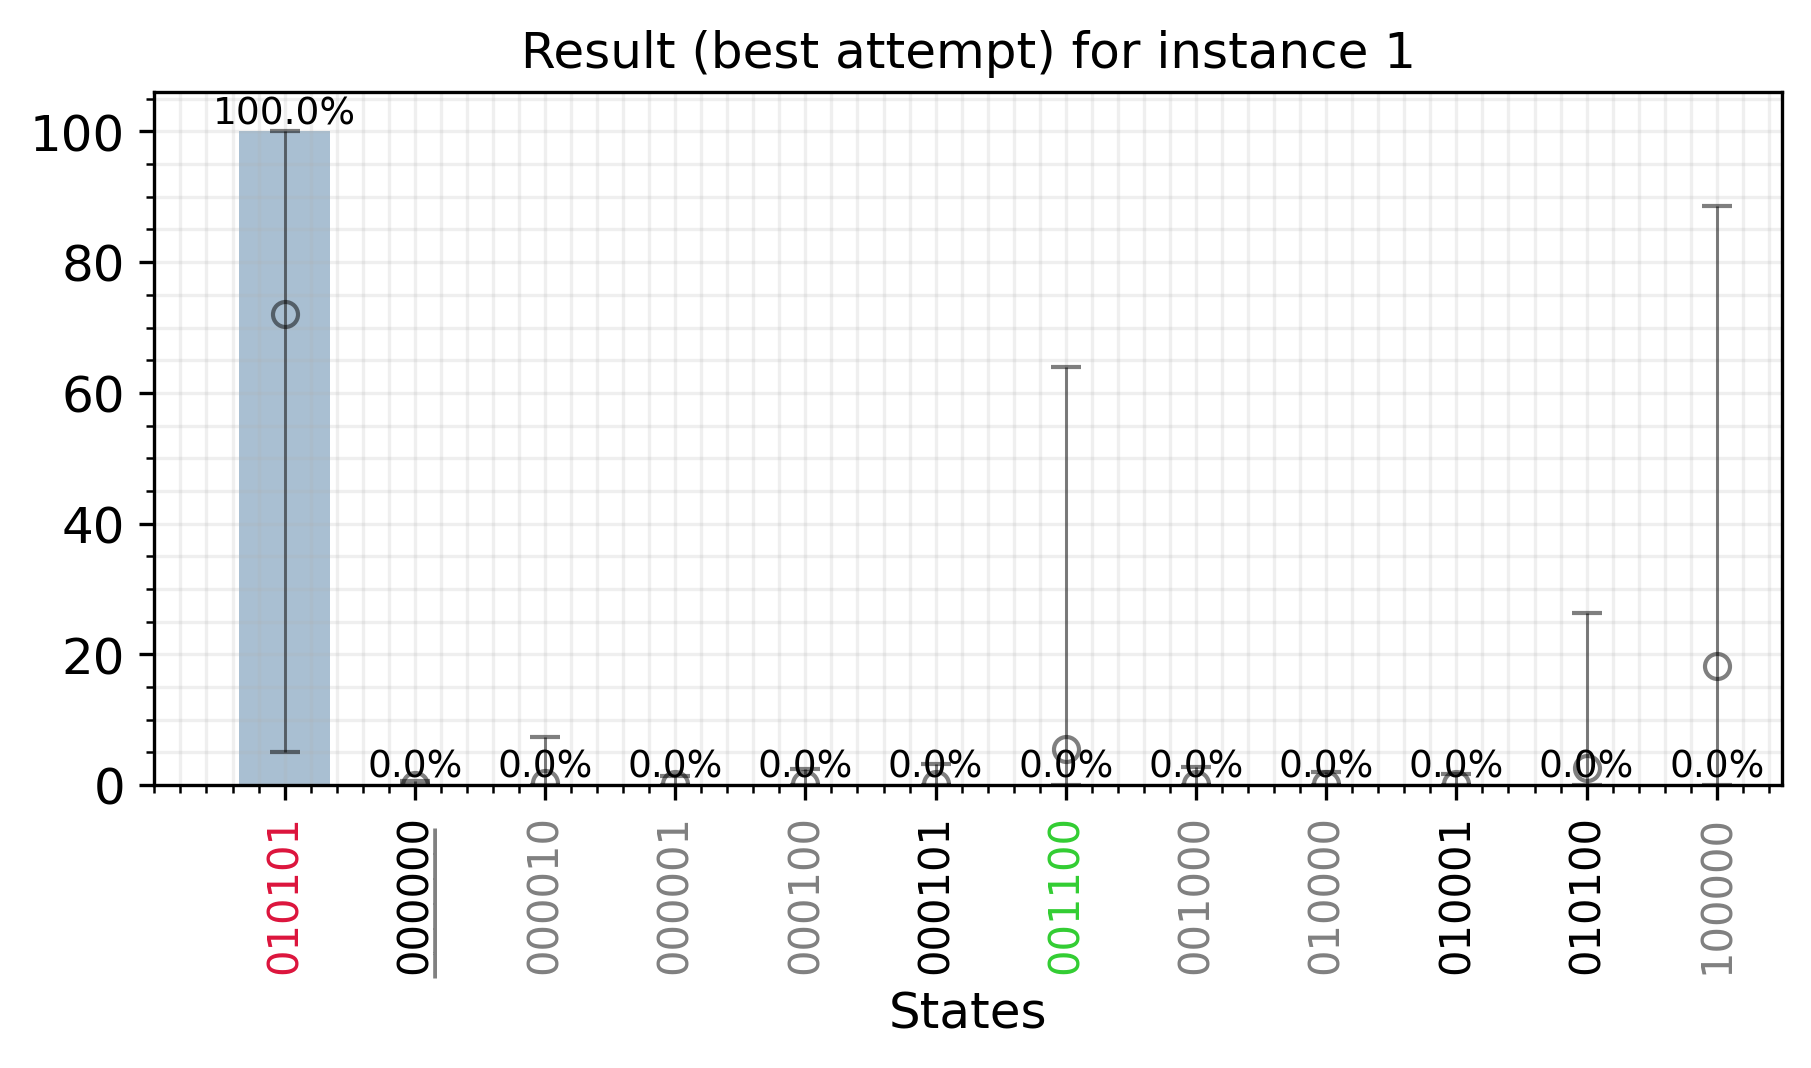

Result saved in:
random_parameters_2025-09-10@08h23m37s/dim6_mail1_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-10@08h23m37s/dim6_mail1_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 45.359322452545165 minutes.
1.0 2
**************************************************
Instance 2 with h = 1.0

U, subsets, EXACT_COVERS, MEC {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} [{8, 9, 11}, {2, 4, 5, 6, 7, 8, 9, 10, 11, 12}, {1, 10, 12, 7}, {2, 3}, {4, 5, 6}, {1, 2, 3, 7, 10, 12}] ['100011', '101110'] ['100011']


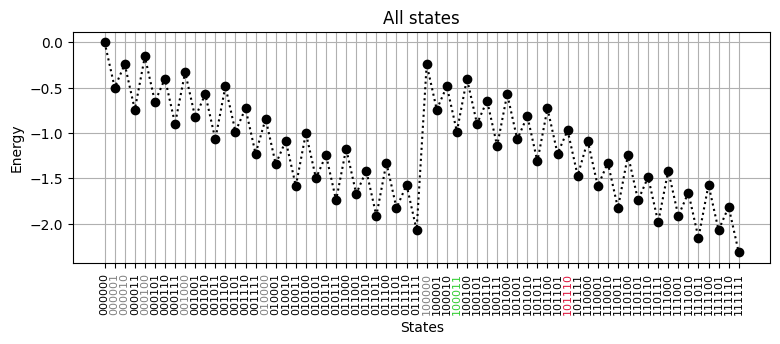

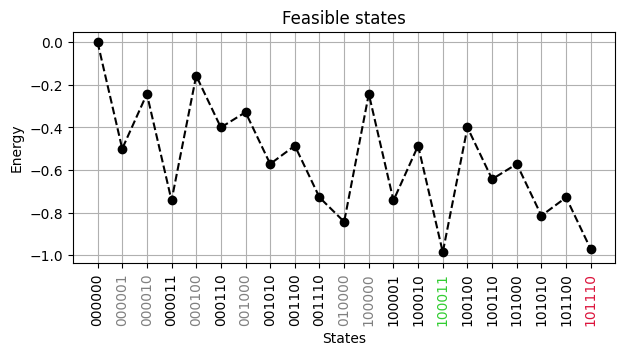

Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {8, 9, 11}
  2: {2, 4, 5, 6, 7, 8, 9, 10, 11, 12}
  3: {1, 10, 12, 7}
  4: {2, 3}
  5: {4, 5, 6}
  6: {1, 2, 3, 7, 10, 12}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
A = 1.2
B = 0.04285714285714286
constant = -A + B = -1.157142857142857

hamiltonian:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII'],
              coeffs=[0.12142857+0.j, 0.42142857+0.j, 0.16428571+0.j, 0.07857143+0.j,
 0.12142857+0.j, 0.25      +0.j])
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {8, 9, 11}
  2: {2, 4, 5, 6, 7, 8, 9, 10, 11, 12}
  3: {1, 10, 12, 7}
  4: {2, 3}
  5: {4, 5, 6}
  6: {1, 2, 3, 7, 10, 12}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
Mixing circuit created for instance 2 with 6 qubits.
Circuit dimension (QC_DIM): 10
Number of ancillas: 4
Number of control gates: 5
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {8, 9, 11}
  2: {2, 4, 5, 6, 7, 8, 9, 10, 11, 1

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9714299186513115
E_min = result.fun = 0.18571293849154555

Optimal parameters: betas, gammas = [np.float64(6.283185307179586), np.float64(3.141537174013319), np.float64(0.538725835074076), np.float64(5.745117519740994)], [np.float64(7.61333535836329), np.float64(-3.7242640429256735), np.float64(5.944412402688162), np.float64(0.0006297202488375199)]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_4of50
0  101110             1024

---------- 5/50 random_attempts -----------

pars_0 = [0.7421131247693543, 5.877398845758961, 2.4059276477076086, 5.682741673871788, -6.5688781001264465, 1.043825962266574, 6.001890675675332, 7.047342375684007]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
    

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9148900696960265
E_min = result.fun = 0.2422527874468305

Optimal parameters: betas, gammas = [np.float64(3.018187590948102), np.float64(4.226428422832422), np.float64(4.636984418247181), np.float64(3.544378025655867)], [np.float64(9.717211824766114), np.float64(9.995090464114131), np.float64(0.28615382470867656), np.float64(0.3861491559877558)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_8of50
16  101110              773
11  100011               88
6   001110               49
12  100100               37
13  101000               15
8   100000               15
7   010000                9
15  101100                8
14  101010                8
9   100001                5
0   000010                4
1   000011                4
4   001000                3
3   000110                2
5   001100                2
2   000100                1
10  100010                1

---------- 9/50 random_attempts -----------

pars_0 = [2.49761994497371

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.856170074758611
E_min = result.fun = 0.3009727823842461

Optimal parameters: betas, gammas = [np.float64(1.4735967902414986), np.float64(1.3897224819766762e-10), np.float64(4.877078118369511), np.float64(3.165134819284332)], [np.float64(2.721539625392965), np.float64(-5.384839956152614), np.float64(5.405750401555991), np.float64(9.995976583525081)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_12of50
11  101110               554
2   001110               323
5   100010                54
3   010000                27
8   100110                24
9   101010                24
6   100011                 8
0   000010                 6
1   000011                 1
4   100000                 1
7   100100                 1
10  101100                 1

---------- 13/50 random_attempts -----------

pars_0 = [0.027227512291667665, 0.9326419979292931, 0.8033638490222867, 4.791741326984385, 0.05714228620707118, -2.2063588589629193, 2.36968084782718

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9221305485004379
E_min = result.fun = 0.23501230864241923

Optimal parameters: betas, gammas = [np.float64(3.0229065171617684), np.float64(4.01320326559512), np.float64(4.657397190494306), np.float64(4.849146040971219)], [np.float64(5.086646678988225), np.float64(-5.63882226581649), np.float64(7.806581165535221), np.float64(3.8707182113168592)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_14of50
12  100011               629
15  101110               147
13  101010               120
3   000011                34
8   001110                18
2   000010                18
9   010000                14
7   001100                 7
14  101100                 7
10  100001                 7
1   000001                 5
0   000000                 5
11  100010                 5
4   000110                 4
6   001010                 3
5   001000                 1

---------- 15/50 random_attempts -----------

pars_0 = [1.8276680816559998, 0.68268

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9101735277731516
E_min = result.fun = 0.2469693293697054

Optimal parameters: betas, gammas = [np.float64(3.219307837678218), np.float64(4.156531946584142), np.float64(4.82003283597424), np.float64(2.8572958529775274)], [np.float64(1.1436151008587716), np.float64(-0.6240591667167941), np.float64(0.3806328726650041), np.float64(-9.992726698504187)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_17of50
15  101110               764
10  100011                63
13  101010                46
5   001110                38
14  101100                30
12  101000                27
11  100100                19
7   100000                11
4   001010                 8
2   000110                 5
9   100010                 4
6   010000                 3
1   000011                 2
8   100001                 2
0   000010                 1
3   001000                 1

---------- 18/50 random_attempts -----------

pars_0 = [5.354652735650359, 4.537

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9459406861087538
E_min = result.fun = 0.21120217103410327

Optimal parameters: betas, gammas = [np.float64(0.9457323194304468), np.float64(2.8401666477634775), np.float64(2.6287671948920783), np.float64(1.7886752170198148)], [np.float64(-3.2883210514740355), np.float64(9.942202754239826), np.float64(3.3370082511489327), np.float64(-7.422721318745197)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_24of50
11  100011               794
17  101110               145
15  101010                25
2   000011                 9
1   000010                 6
0   000001                 6
13  100110                 5
3   000100                 5
5   001010                 5
4   000110                 4
9   100000                 4
7   001110                 4
12  100100                 3
8   010000                 3
16  101100                 2
10  100010                 2
6   001100                 1
14  101000                 1

---------- 25/50 r

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9148966178420728
E_min = result.fun = 0.24224623930078426

Optimal parameters: betas, gammas = [np.float64(3.0188302155699156), np.float64(4.223675113270232), np.float64(4.6334716227016015), np.float64(3.546756352985656)], [np.float64(3.606409748153293), np.float64(9.995976607711814), np.float64(0.29238780193764635), np.float64(0.39839526424332494)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_28of50
16  101110               748
10  100011                99
5   001110                58
13  101000                41
11  100100                25
15  101100                10
7   100000                 9
14  101010                 6
6   010000                 6
0   000010                 4
4   001000                 4
8   100001                 4
2   000100                 3
3   000110                 3
1   000011                 2
12  100110                 1
9   100010                 1

---------- 29/50 random_attempts -----------

par

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9714285714285711
E_min = result.fun = 0.1857142857142859

Optimal parameters: betas, gammas = [np.float64(6.28318528502001), np.float64(3.141592663556371), np.float64(6.283185298837881), np.float64(4.4953114009567385e-09)], [np.float64(-0.0011396430971129055), np.float64(9.990045909199571), np.float64(-9.995976625058432), np.float64(9.980313509964237)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_31of50
0  101110              1024

---------- 32/50 random_attempts -----------

pars_0 = [2.021857486917107, 4.787827133954831, 1.9599862952967781, 5.134077496779961, 1.714780971653072, 5.112498941070774, -6.861179923012907, -3.3573520130141876]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated success

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9476181142377044
E_min = result.fun = 0.2095247429051527

Optimal parameters: betas, gammas = [np.float64(0.9804066025367715), np.float64(2.8610709412780357), np.float64(2.65024515539245), np.float64(1.795076536251408)], [np.float64(-9.187570231328465), np.float64(-9.995976394303646), np.float64(-3.4196772224032834), np.float64(7.369321370964322)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_34of50
11  100011               776
17  101110               171
15  101010                21
13  100110                10
3   000011                 9
9   100000                 5
12  100100                 5
0   000000                 4
2   000010                 4
7   001110                 4
1   000001                 2
6   001010                 2
4   000100                 2
5   000110                 2
8   010000                 2
14  101000                 2
16  101100                 2
10  100010                 1

---------- 35/50 rando

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9714316504116662
E_min = result.fun = 0.18571120673119074

Optimal parameters: betas, gammas = [np.float64(0.016690467308649384), np.float64(3.129236109170702), np.float64(0.8396066263966572), np.float64(5.446488994603021)], [np.float64(-1.929611238802344), np.float64(3.416800927324023), np.float64(3.031009303126711), np.float64(0.05019504541273495)]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_39of50
1  101110              1018
0  100011                 6

---------- 40/50 random_attempts -----------

pars_0 = [1.5912065632567742, 3.7691198685257374, 2.297279021345064, 2.831973780437419, 3.6358496753569938, 2.6411105167077675, 1.1032859349076478, 2.8632232797321997]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimiz

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9592433496995227
E_min = result.fun = 0.19789950744333432

Optimal parameters: betas, gammas = [np.float64(0.685333294385702), np.float64(1.599750112966996), np.float64(1.2073641850321968), np.float64(6.207491017615329)], [np.float64(7.014030808083106), np.float64(3.3838773408731413), np.float64(-2.157453364258804), np.float64(5.319497663989278)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_42of50
11  101110               961
7   100011                26
6   100010                12
9   101010                12
10  101100                 4
1   000010                 3
0   000001                 1
2   000110                 1
3   001000                 1
5   001110                 1
4   001100                 1
8   100110                 1

---------- 43/50 random_attempts -----------

pars_0 = [2.4429829118012885, 3.205684079385798, 1.7374004697642873, 5.606829991737425, 0.2769889860318262, -6.860618462253059, 1.8822055334432228, -0.

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9655700330793748
E_min = result.fun = 0.19157282406348214

Optimal parameters: betas, gammas = [np.float64(3.10511254649634), np.float64(5.772111941000809), np.float64(1.780159303230512), np.float64(4.952261770962357)], [np.float64(0.713401543890531), np.float64(1.4195807169229955), np.float64(-0.6717692762395671), np.float64(-0.5849714732629088)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_45of50
7  101110               899
3  100011                99
4  100110                12
5  101010                 5
2  100010                 4
6  101100                 3
0  000011                 1
1  001110                 1

---------- 46/50 random_attempts -----------

pars_0 = [2.000784266331708, 0.8207473497149989, 2.20210868646749, 5.138651913870937, 1.7171710666686835, -0.18852165924985798, -8.030222148098144, -1.552352855930197]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9331202055634193
E_min = result.fun = 0.22402265157943768

Optimal parameters: betas, gammas = [np.float64(0.8705112592744157), np.float64(2.2850789898093877), np.float64(5.588293996323552), np.float64(5.368873393966139)], [np.float64(2.374930443535164), np.float64(-9.995976565727204), np.float64(-9.280825984064002), np.float64(-1.6318146308460948)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_49of50
14  101110               500
9   100011               327
6   010000                93
12  101010                49
10  100110                17
3   001010                11
8   100010                 8
11  101000                 5
7   100001                 4
0   000000                 3
4   001100                 2
5   001110                 2
2   000011                 1
1   000001                 1
13  101100                 1

---------- 50/50 random_attempts -----------

pars_0 = [2.09765585673424, 3.630384860912971, 1.897340655381

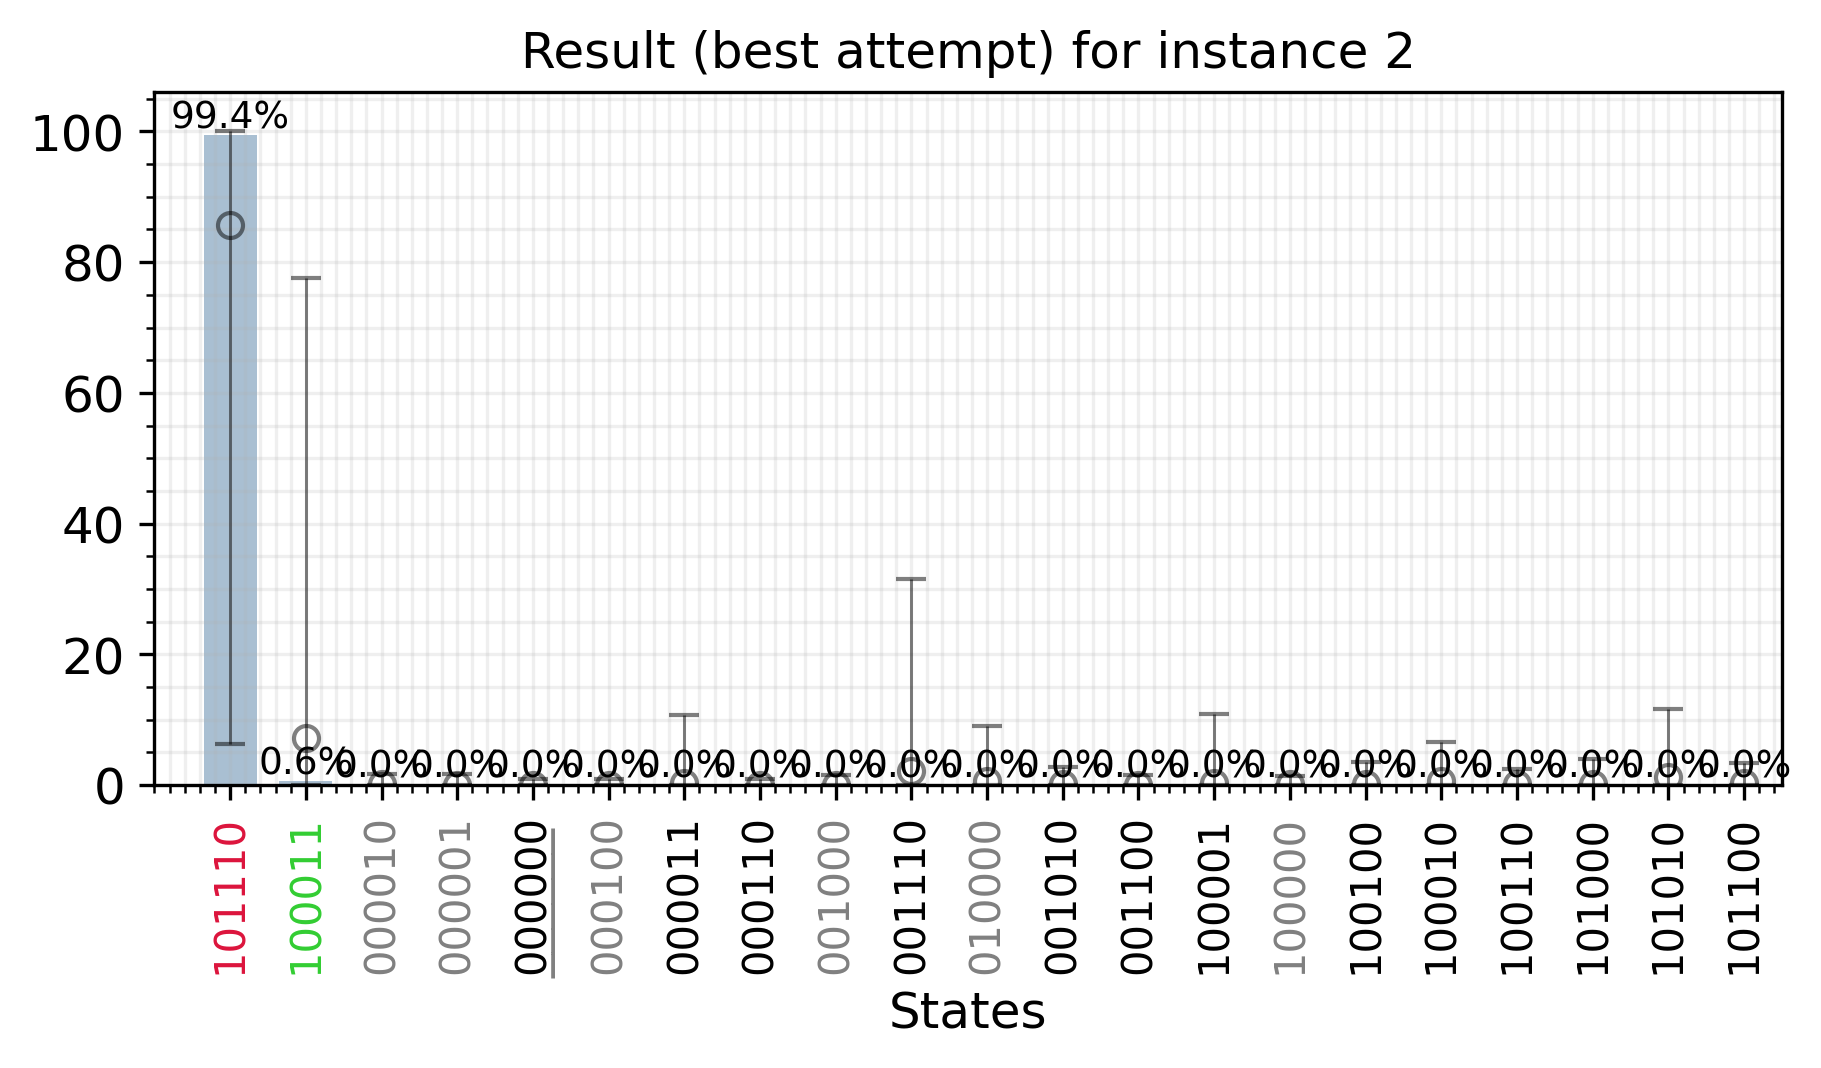

Result saved in:
random_parameters_2025-09-10@08h23m37s/dim6_mail2_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-10@08h23m37s/dim6_mail2_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 32.56272190411885 minutes.
1.0 3
**************************************************
Instance 3 with h = 1.0

U, subsets, EXACT_COVERS, MEC {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} [{2, 10, 4, 5}, {1, 3, 4, 5, 6, 7, 9, 10, 11, 12}, {3, 7, 8, 9, 11, 12}, {2, 10}, {4, 5}, {1, 6}] ['001111', '101001'] ['101001']


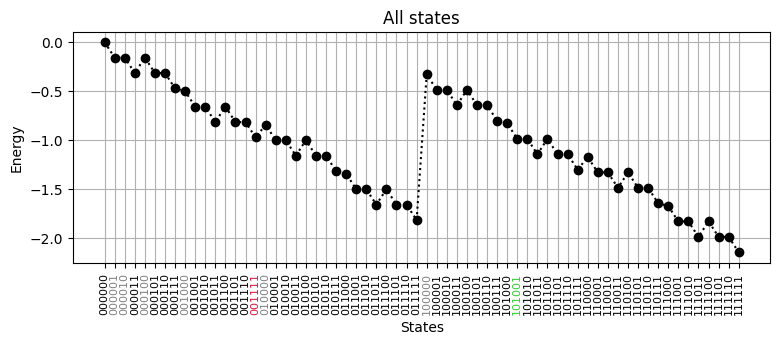

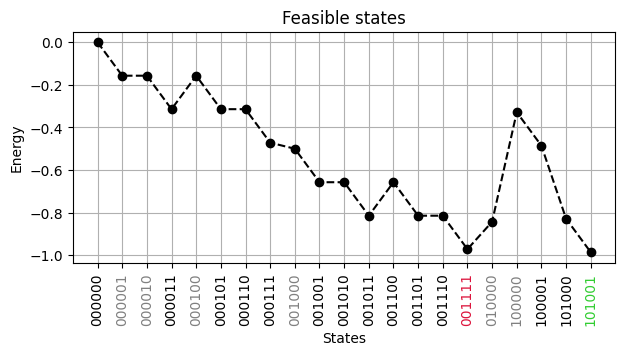

Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {2, 10, 4, 5}
  2: {1, 3, 4, 5, 6, 7, 9, 10, 11, 12}
  3: {3, 7, 8, 9, 11, 12}
  4: {2, 10}
  5: {4, 5}
  6: {1, 6}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
A = 1.1142857142857143
B = 0.04285714285714286
constant = -A + B = -1.0714285714285714

hamiltonian:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII'],
              coeffs=[0.16428571+0.j, 0.42142857+0.j, 0.25      +0.j, 0.07857143+0.j,
 0.07857143+0.j, 0.07857143+0.j])
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {2, 10, 4, 5}
  2: {1, 3, 4, 5, 6, 7, 9, 10, 11, 12}
  3: {3, 7, 8, 9, 11, 12}
  4: {2, 10}
  5: {4, 5}
  6: {1, 6}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
Mixing circuit created for instance 3 with 6 qubits.
Circuit dimension (QC_DIM): 10
Number of ancillas: 4
Number of control gates: 5
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {2, 10, 4, 5}
  2: {1, 3, 4, 5, 6, 7, 9, 10, 

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9521710934855664
E_min = result.fun = 0.11925747794300504

Optimal parameters: betas, gammas = [np.float64(1.3699190652083382), np.float64(5.171255029599435), np.float64(0.639276817405992), np.float64(1.9199301246040248)], [np.float64(8.721834084753356), np.float64(9.339183947461446), np.float64(0.4185410421030743), np.float64(-9.39198982198052)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_4of50
8   001111              637
12  101001              330
10  100001               19
4   001011                7
1   000111                7
7   001110                6
6   001101                5
0   000011                3
2   001000                3
9   010000                2
5   001100                2
11  101000                2
3   001010                1

---------- 5/50 random_attempts -----------

pars_0 = [4.220589232982179, 3.24554302191277, 1.0371305615456199, 1.9423967597549798, 4.810895601343413, -5.9621203581692095, -2.7398366

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9857142857142854
E_min = result.fun = 0.08571428571428599

Optimal parameters: betas, gammas = [np.float64(3.141592631569064), np.float64(6.283185307179586), np.float64(0.0), np.float64(0.0)], [np.float64(-6.932748114272403), np.float64(1.6695004475728332), np.float64(0.9506065989511483), np.float64(1.1054035095237924)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_8of50
0  101001             1024

---------- 9/50 random_attempts -----------

pars_0 = [4.517027533077763, 2.438614724908042, 3.2655045418463, 3.441920891913761, 3.1937545144249313, 6.849027684913107, 1.076661271364772, 5.698588186945212]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         Current function value: 0

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.847833989730521
E_min = result.fun = 0.22359458169805038

Optimal parameters: betas, gammas = [np.float64(6.259657548429541), np.float64(1.6586455014699388), np.float64(4.890465155658934), np.float64(2.831111913520445)], [np.float64(4.347027156471171), np.float64(-9.995976427896768), np.float64(0.1984889466500373), np.float64(9.995976615423341)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_10of50
14  001111               447
15  010000               148
12  001101               118
10  001011               108
8   001001                83
13  001110                24
11  001100                18
3   000011                17
9   001010                11
5   000101                10
1   000001                10
6   000111                 8
7   001000                 7
19  101001                 4
18  101000                 4
17  100001                 2
16  100000                 2
0   000000                 1
2   000010               

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9294711991409677
E_min = result.fun = 0.14195737228760372

Optimal parameters: betas, gammas = [np.float64(4.37516104808199), np.float64(2.7629194947518023), np.float64(3.214283778323658), np.float64(1.7263449189847133)], [np.float64(-0.9673835630085175), np.float64(-6.545453375611515), np.float64(9.995975969351392), np.float64(-2.3849451882158412)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_11of50
18  101001               607
13  001111               205
14  010000                54
17  101000                53
12  001110                39
15  100000                13
5   000110                 7
7   001001                 6
4   000101                 6
2   000011                 6
8   001010                 5
11  001101                 4
9   001011                 4
10  001100                 4
3   000100                 3
16  100001                 3
0   000000                 2
6   001000                 2
1   000001           

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9528690740142709
E_min = result.fun = 0.11855949741430051

Optimal parameters: betas, gammas = [np.float64(1.462324077089992), np.float64(5.470726632982899), np.float64(1.9754544649966057), np.float64(0.3543615117874137)], [np.float64(1.193372439369119), np.float64(-8.572495880576845), np.float64(8.460916481938565), np.float64(5.614305177873401)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_16of50
10  001111               738
13  101001               238
5   001001                13
9   001110                10
4   000110                 6
11  100001                 5
12  101000                 3
6   001010                 2
2   000100                 2
3   000101                 2
7   001011                 2
1   000011                 1
0   000000                 1
8   001101                 1

---------- 17/50 random_attempts -----------

pars_0 = [0.9223258287535404, 1.719424986482421, 1.7512979089386134, 1.7421606898584578, 4.27

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9429656355836238
E_min = result.fun = 0.12846293584494767

Optimal parameters: betas, gammas = [np.float64(1.42438152753126), np.float64(6.130228537701836), np.float64(4.916466305997556), np.float64(3.4176698492554287)], [np.float64(6.831610594706689), np.float64(6.93363804555452), np.float64(-6.887218721112326), np.float64(5.981519548087661)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_20of50
17  101001               542
13  001111               277
14  010000               132
12  001110                25
4   000110                10
9   001011                 9
11  001101                 8
16  101000                 6
7   001001                 4
5   000111                 2
8   001010                 2
0   000000                 1
1   000011                 1
3   000101                 1
6   001000                 1
2   000100                 1
10  001100                 1
15  100000                 1

---------- 21/50 random_at

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9485863693610508
E_min = result.fun = 0.12284220206752067

Optimal parameters: betas, gammas = [np.float64(0.12558126714208223), np.float64(3.240622608892931), np.float64(5.288335864818663), np.float64(1.1520682846956056)], [np.float64(4.138536911574814), np.float64(4.911729599250556), np.float64(-7.353397960868733), np.float64(-0.32554551292871114)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_28of50
12  101001               817
7   001101                64
6   001011                61
8   001111                33
11  101000                16
5   001001                14
10  100001                12
1   000011                 2
0   000001                 1
4   000111                 1
3   000101                 1
2   000100                 1
9   010000                 1

---------- 29/50 random_attempts -----------

pars_0 = [1.0849264012222548, 1.941646439525401, 5.8439725680218855, 4.21225305065174, 4.2470839166605625, 8.595012395

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9857142857139236
E_min = result.fun = 0.08571428571464777

Optimal parameters: betas, gammas = [np.float64(3.1415939988762114), np.float64(6.283185307179586), np.float64(0.0), np.float64(0.0)], [np.float64(2.858190703396713), np.float64(9.995976625058432), np.float64(-4.896687699116819), np.float64(5.1141948826639165)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_30of50
0  101001              1024

---------- 31/50 random_attempts -----------

pars_0 = [6.047706205390017, 3.972921616162299, 4.571158882678831, 2.4266722705672796, 0.8289883601037129, 1.0910570642915953, 5.638021534640558, -3.888518579842156]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         Current function v

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9358369695824791
E_min = result.fun = 0.13559160184609237

Optimal parameters: betas, gammas = [np.float64(4.899984069595019), np.float64(5.300745852248671), np.float64(0.5736245341433426), np.float64(1.880303502506939)], [np.float64(7.479109703846751), np.float64(9.45292681511511), np.float64(-0.8431618889899186), np.float64(9.767865148041492)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_35of50
13  001111               565
18  101001               325
11  001101                26
12  001110                23
9   001011                22
6   000111                18
16  100001                17
14  010000                 9
17  101000                 5
3   000011                 3
1   000001                 2
2   000010                 2
0   000000                 1
10  001100                 1
5   000110                 1
4   000101                 1
8   001010                 1
7   001000                 1
15  100000               

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9857142857142851
E_min = result.fun = 0.08571428571428624

Optimal parameters: betas, gammas = [np.float64(3.1415927019548153), np.float64(6.283185307179586), np.float64(6.283185307179586), np.float64(0.0)], [np.float64(6.440574625605288), np.float64(-8.666411536588669), np.float64(9.246947048619516), np.float64(-0.07600105557431186)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_37of50
0  101001              1024

---------- 38/50 random_attempts -----------

pars_0 = [4.8811455189799275, 0.026337622786280702, 3.3691275239834617, 1.0682402901465735, -1.177295863259479, 3.617984313794828, -8.47081365908161, -6.929386061516077]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
       

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9030530013555582
E_min = result.fun = 0.16837557007301324

Optimal parameters: betas, gammas = [np.float64(6.283185307179576), np.float64(1.5973567103161237), np.float64(6.283185307179437), np.float64(2.020574353558711)], [np.float64(-2.5688673841208516), np.float64(6.2140338919771985), np.float64(2.6820037622688915), np.float64(-2.682003847574343)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_41of50
11  001111               658
15  101001               166
13  100001                62
14  101000                53
5   001001                29
7   001011                17
9   001101                12
4   000110                10
3   000101                 4
6   001010                 4
0   000010                 3
1   000011                 2
2   000100                 1
8   001100                 1
10  001110                 1
12  010000                 1

---------- 42/50 random_attempts -----------

pars_0 = [1.9844060156773564, 0.

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9857142757589686
E_min = result.fun = 0.08571429566960279

Optimal parameters: betas, gammas = [np.float64(3.141575963967422), np.float64(0.07625823116951402), np.float64(6.1593625578442115), np.float64(0.04770879097575302)], [np.float64(7.351471117817095), np.float64(-9.284065201395524), np.float64(-0.05330580196262955), np.float64(-0.08589966125688234)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_42of50
0  101001              1024

---------- 43/50 random_attempts -----------

pars_0 = [1.7284007121353337, 0.28275125235448023, 4.145058746207966, 2.0456183358660303, -1.4045913311230738, -2.9794928138250008, -9.66670313428059, -2.2007871224456066]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminate

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9205083746121777
E_min = result.fun = 0.1509201968163937

Optimal parameters: betas, gammas = [np.float64(4.934116824110028), np.float64(6.204780331671856), np.float64(1.3107730169972989), np.float64(2.8371300580477516)], [np.float64(8.111279174545896), np.float64(-9.897383316743412), np.float64(9.994888044672397), np.float64(-7.999235838294059)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_45of50
7   001111               469
8   010000               221
12  101001               217
6   001110                53
4   001011                13
2   000110                12
3   001001                12
5   001101                11
11  101000                10
9   100000                 2
0   000010                 2
1   000101                 1
10  100001                 1

---------- 46/50 random_attempts -----------

pars_0 = [4.255921075450211, 1.9168949066509549, 2.045770361781802, 4.820519739629447, 9.165373964120125, -7.2312274034441

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8408315992162636
E_min = result.fun = 0.23059697221230774

Optimal parameters: betas, gammas = [np.float64(3.6847832936140748), np.float64(3.602744384853195), np.float64(3.156653970188195), np.float64(4.8899601573439995)], [np.float64(-9.921498062251146), np.float64(-0.16074208861563177), np.float64(-9.995976625058432), np.float64(-9.99584706689653)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_49of50
19  101001               251
12  001101               200
14  001111               189
10  001011               180
17  100001                49
6   000111                25
8   001001                22
18  101000                21
13  001110                20
15  010000                15
16  100000                15
3   000100                11
2   000011                 5
9   001010                 5
5   000110                 4
0   000000                 3
4   000101                 3
1   000010                 2
11  001100          

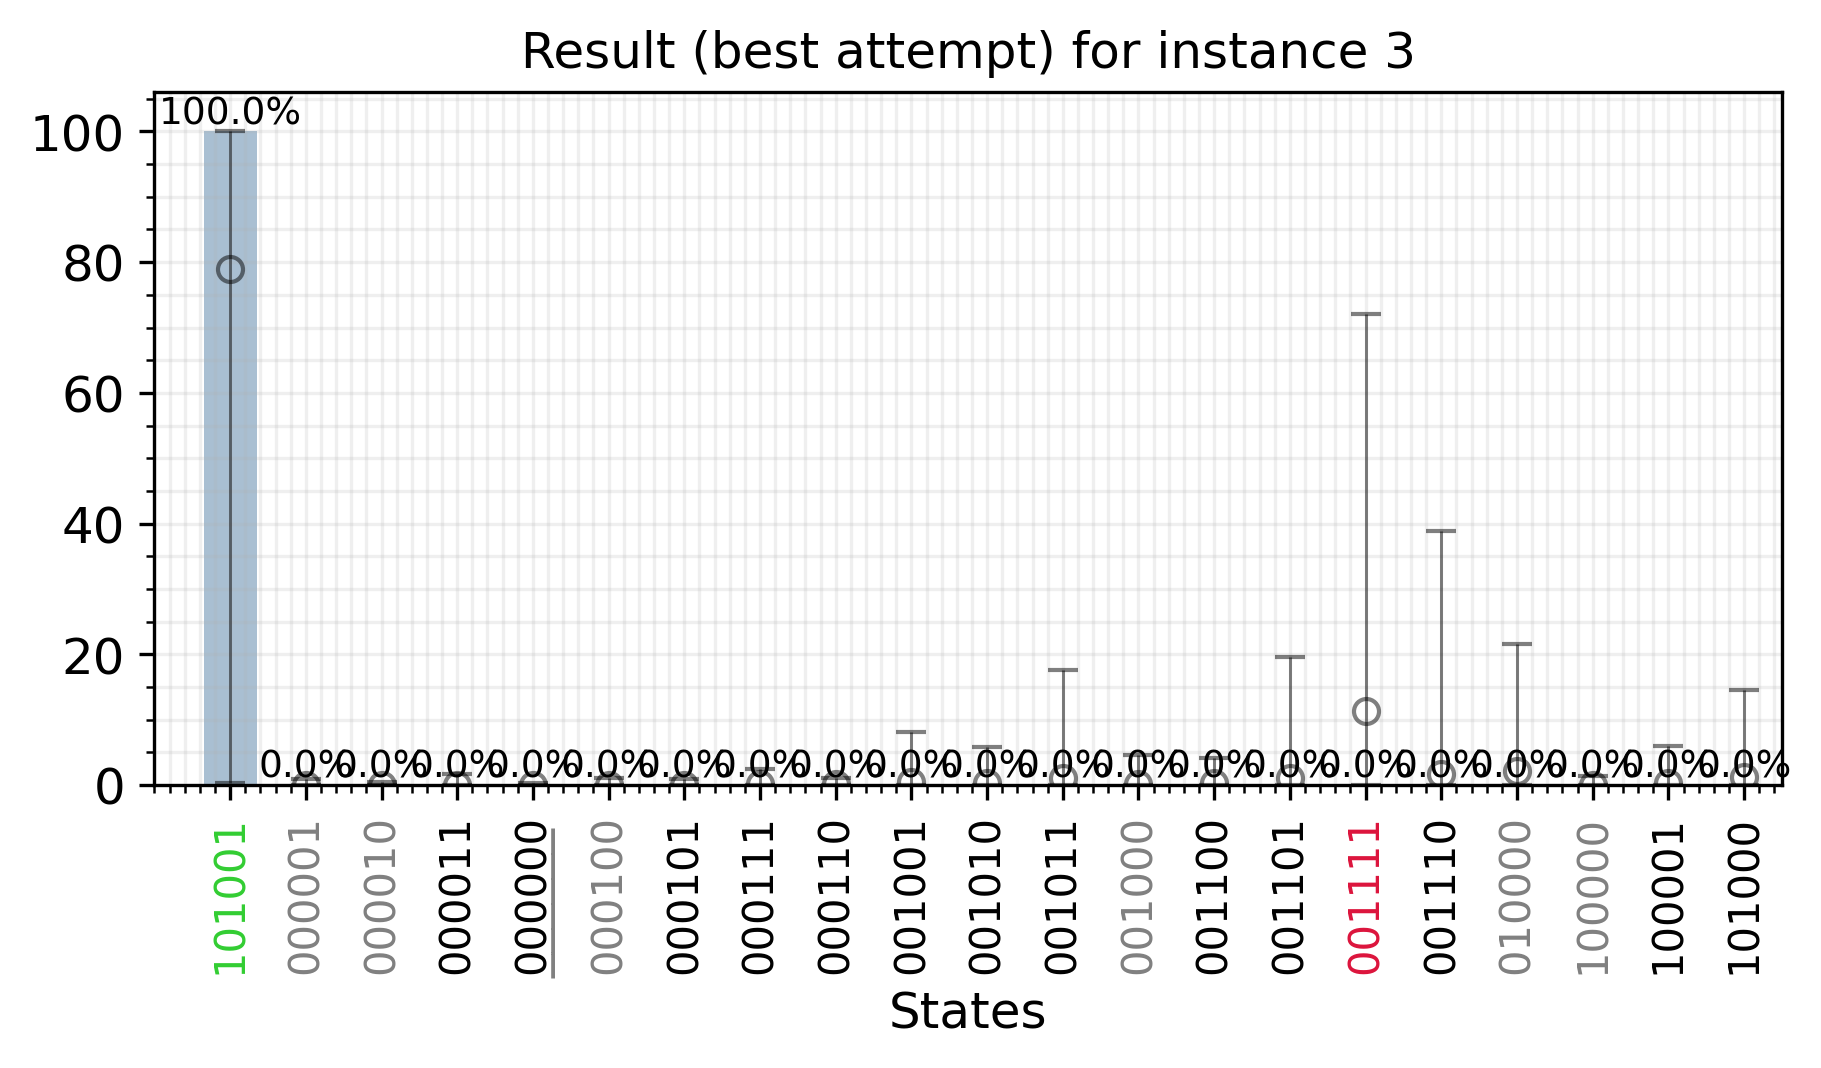

Result saved in:
random_parameters_2025-09-10@08h23m37s/dim6_mail3_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-10@08h23m37s/dim6_mail3_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 31.09883821805318 minutes.
1.0 4
**************************************************
Instance 4 with h = 1.0

U, subsets, EXACT_COVERS, MEC {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} [{3, 4, 12, 7}, {5, 6}, {3, 4, 5, 6, 7, 12}, {1, 4, 5, 6, 7, 8, 9, 10, 11, 12}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 11}, {1, 2, 8, 9, 10, 11}] ['001001', '110001'] ['001001']


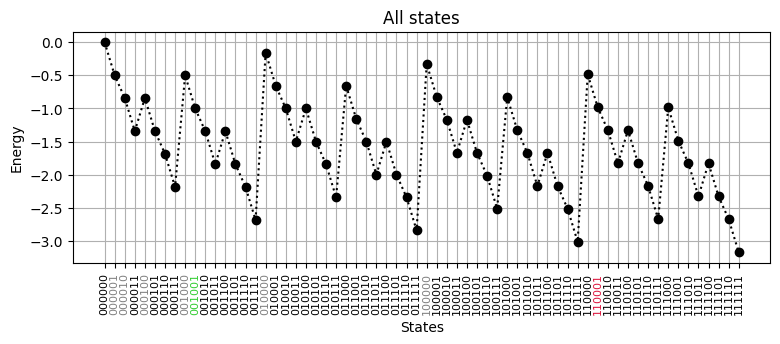

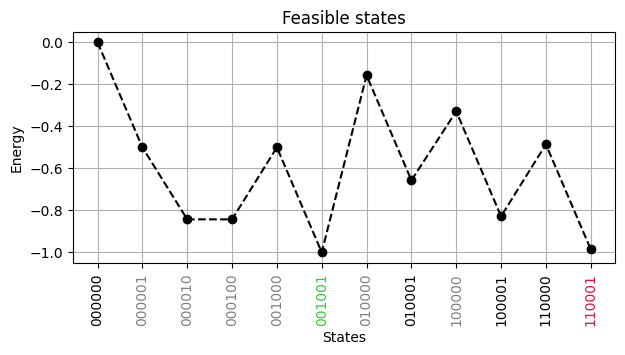

Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {3, 4, 12, 7}
  2: {5, 6}
  3: {3, 4, 5, 6, 7, 12}
  4: {1, 4, 5, 6, 7, 8, 9, 10, 11, 12}
  5: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11}
  6: {1, 2, 8, 9, 10, 11}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
A = 1.6285714285714286
B = 0.04285714285714286
constant = -A + B = -1.5857142857142856

hamiltonian:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII'],
              coeffs=[0.16428571+0.j, 0.07857143+0.j, 0.25      +0.j, 0.42142857+0.j,
 0.42142857+0.j, 0.25      +0.j])
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {3, 4, 12, 7}
  2: {5, 6}
  3: {3, 4, 5, 6, 7, 12}
  4: {1, 4, 5, 6, 7, 8, 9, 10, 11, 12}
  5: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11}
  6: {1, 2, 8, 9, 10, 11}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
Mixing circuit created for instance 4 with 6 qubits.
Circuit dimension (QC_DIM): 10
Number of ancillas: 4
Number of control gates: 5
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9788061012010519
E_min = result.fun = 0.6069081845132337

Optimal parameters: betas, gammas = [np.float64(4.424423213030931), np.float64(0.24135041634658927), np.float64(2.6633709741412996), np.float64(1.4796625203763596)], [np.float64(2.8162545233160983), np.float64(7.682173257619182), np.float64(-1.1257120846293855), np.float64(6.590775967461194)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_4of50
5   001001              817
11  110001              148
2   000010               32
7   010001                6
9   100001                4
4   001000                4
3   000100                4
0   000000                3
10  110000                2
6   010000                2
1   000001                1
8   100000                1

---------- 5/50 random_attempts -----------

pars_0 = [4.521572823725496, 2.3351738373412774, 1.7354368353361695, 0.4988629640157665, -5.914263379044606, 8.348361719609173, -6.386431115116012, 8.087017871022

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9646646353742897
E_min = result.fun = 0.6210496503399959

Optimal parameters: betas, gammas = [np.float64(3.5115745936804608), np.float64(1.51523112055904), np.float64(2.8112824022484695), np.float64(4.887931300954419)], [np.float64(-9.792997974774963), np.float64(-9.993999908344716), np.float64(3.1483965279046444), np.float64(9.995727057915879)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_8of50
4  001001              700
8  110001              212
2  000100               39
7  100001               26
5  010001               23
0  000001               16
1  000010                4
3  001000                2
6  100000                2

---------- 9/50 random_attempts -----------

pars_0 = [2.130135873263153, 1.5623405854993324, 3.3138682142397182, 2.535304843784628, 8.471831784267344, -2.810310373499429, -5.148510034556248, -7.5869513850011785]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.28318

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9454667931740344
E_min = result.fun = 0.6402474925402513

Optimal parameters: betas, gammas = [np.float64(3.7704102487666575), np.float64(0.8583076176457163), np.float64(4.3340403506237015), np.float64(4.083444137572088)], [np.float64(-0.600663749111065), np.float64(-3.683341717664954), np.float64(-2.47803512621092), np.float64(-7.89511413261189)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_9of50
5   001001              563
11  110001              212
9   100001              197
7   010001               16
2   000010               14
8   100000                5
3   000100                4
1   000001                3
0   000000                3
6   010000                3
10  110000                3
4   001000                1

---------- 10/50 random_attempts -----------

pars_0 = [1.3319791729786383, 0.601264054348287, 1.9099430035523524, 3.3753469293724807, 8.839022635364532, 0.07521523704076216, 1.4380199720330484, 4.012701416843

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9872269925515844
E_min = result.fun = 0.5984872931627012

Optimal parameters: betas, gammas = [np.float64(2.280991707439249), np.float64(0.8495132313415199), np.float64(1.5171299043590998), np.float64(4.808901033730564)], [np.float64(9.995395934795635), np.float64(0.016574098657406423), np.float64(-0.012335505144987992), np.float64(0.01552094982509681)]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_10of50
3  110001               810
2  001001               212
1  000001                 1
0  000000                 1

---------- 11/50 random_attempts -----------

pars_0 = [2.490898206435827, 3.52374450230014, 0.8168473097715404, 1.7419853529426306, 9.224777584285984, 9.790825563590637, -6.747128701707883, -3.9653051528586616]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.9959766250

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9527035319849159
E_min = result.fun = 0.6330107537293698

Optimal parameters: betas, gammas = [np.float64(4.972547933140513), np.float64(4.85860766512547), np.float64(0.03940657609913672), np.float64(1.9027816117077117)], [np.float64(8.260261315205348), np.float64(8.781113052732382), np.float64(-9.995976602053968), np.float64(-6.127365736254262)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_11of50
10  110001               905
8   100001                34
2   000010                30
6   010001                26
4   001001                 7
1   000001                 6
0   000000                 6
3   000100                 5
9   110000                 3
5   010000                 1
7   100000                 1

---------- 12/50 random_attempts -----------

pars_0 = [6.029332788896941, 2.957867512841282, 0.7697004606853116, 3.5492586954221634, 9.759635435107281, 9.882838570107527, 9.68077021938634, 1.1037469095271462]
bnds = [(0, 6.28

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9857156920765959
E_min = result.fun = 0.5999985936376897

Optimal parameters: betas, gammas = [np.float64(6.283185202948397), np.float64(3.141102418374082), np.float64(0.5379494957492434), np.float64(5.745835654483951)], [np.float64(9.676104680423258), np.float64(9.383542345904722), np.float64(9.985440053153372), np.float64(-0.0013255421449382791)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_12of50
0  110001              1024

---------- 13/50 random_attempts -----------

pars_0 = [2.9239970279391545, 1.8808369727372125, 2.4917102856436424, 4.046065341769754, 6.211584260489317, -6.884942298077077, 7.904398502358944, 9.965113397140307]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9646781659163762
E_min = result.fun = 0.6210361197979094

Optimal parameters: betas, gammas = [np.float64(3.51918069685684), np.float64(1.5214061189017283), np.float64(2.812721479101472), np.float64(4.895354400056435)], [np.float64(-9.869535295702256), np.float64(-9.995494914353046), np.float64(3.1334643804555373), np.float64(9.994744343470355)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_13of50
5  001001               660
9  110001               250
3  000100                32
6  010001                31
7  100001                26
1  000001                17
0  000000                 2
2  000010                 2
4  001000                 2
8  110000                 2

---------- 14/50 random_attempts -----------

pars_0 = [2.533874983439705, 4.050687789939748, 0.164864029899475, 1.3028588606158058, 8.338191137669227, -3.100552096639281, 7.481779413359771, -7.610331960161069]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), 

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9560493544832764
E_min = result.fun = 0.6296649312310092

Optimal parameters: betas, gammas = [np.float64(2.1160160513024087), np.float64(2.4787267696639512), np.float64(0.0), np.float64(1.75990324725621)], [np.float64(9.995964458952205), np.float64(-2.4898259317923674), np.float64(7.324537965597839), np.float64(-3.2053112133074135)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_14of50
3  001001               616
9  110001               199
7  100001               172
5  010001                15
8  110000                 7
1  000010                 6
2  000100                 6
0  000000                 1
4  010000                 1
6  100000                 1

---------- 15/50 random_attempts -----------

pars_0 = [1.0825444496065129, 0.36466303554062585, 0.006109415533334157, 2.877643296614042, -1.6980644939715095, -8.83609638781296, -9.854263871055986, 3.747432093472817]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8745276819104045
E_min = result.fun = 0.7111866038038811

Optimal parameters: betas, gammas = [np.float64(6.219099584738407), np.float64(2.039092783551543), np.float64(1.4910209608950509), np.float64(2.5801128746406508)], [np.float64(-7.219378191777327), np.float64(-9.995594335985544), np.float64(-6.104496574152609), np.float64(-5.361664323878722)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_17of50
5   001001               412
3   000100               297
8   100001               250
0   000000                20
9   110000                16
2   000010                 9
4   001000                 7
1   000001                 5
10  110001                 4
6   010001                 2
7   100000                 2

---------- 18/50 random_attempts -----------

pars_0 = [2.2547120266883516, 5.161511063084463, 1.8751370497468283, 0.5277368563271181, 3.692746529320745, 4.749358485062768, -6.228166206476124, -9.634731011871946]
bnds = [(0,

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9592645453300457
E_min = result.fun = 0.62644974038424

Optimal parameters: betas, gammas = [np.float64(2.0565987664730203), np.float64(2.6902828291066605), np.float64(0.8514031470309273), np.float64(1.017241951829957)], [np.float64(7.063747205793721), np.float64(-2.4785562764057065), np.float64(4.339944899484337), np.float64(-0.37577984605496106)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_19of50
2  001001               616
7  110001               236
5  100001               136
3  010001                23
1  000100                 5
6  110000                 4
0  000010                 3
4  100000                 1

---------- 20/50 random_attempts -----------

pars_0 = [3.359040291114658, 1.9444746568551765, 2.0973119070630655, 4.676521992027929, 5.526388748851151, 2.763318719133096, 8.788459075839143, 1.4622433097115]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.9959

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9595048599537576
E_min = result.fun = 0.6262094257605281

Optimal parameters: betas, gammas = [np.float64(2.998510277559257), np.float64(1.2609490506127345), np.float64(2.750789455567232), np.float64(4.793965673814409)], [np.float64(0.9417602769356193), np.float64(4.637659844644971), np.float64(8.641575608604207), np.float64(2.2441036209437883)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_20of50
5   001001               637
10  110001               214
9   100001               148
7   010001                12
4   001000                 4
0   000000                 3
1   000001                 2
2   000010                 1
3   000100                 1
6   010000                 1
8   100000                 1

---------- 21/50 random_attempts -----------

pars_0 = [5.183684641313079, 2.5567268988820033, 5.653356005473867, 3.370726210883383, 9.447962469951396, 3.391357338867399, 8.537211989746176, 2.9993745939877563]
bnds = [(0, 6.283

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9539970696687836
E_min = result.fun = 0.631717216045502

Optimal parameters: betas, gammas = [np.float64(2.675487782969519), np.float64(4.56055313164693), np.float64(5.713162694156313), np.float64(4.750205123073993)], [np.float64(7.6914974188908865), np.float64(8.036998289594319), np.float64(3.2272257658840875), np.float64(3.7469814531261996)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_21of50
4  110001               735
3  100001               162
1  001001               115
2  010001                 9
0  000100                 3

---------- 22/50 random_attempts -----------

pars_0 = [4.126797715619411, 0.23239110282093384, 1.2256857814685767, 1.9531412181260641, 4.0101947336830985, 9.157644531949714, 4.023907002819236, -6.544150230737127]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.99597

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9205261060959694
E_min = result.fun = 0.6651881796183162

Optimal parameters: betas, gammas = [np.float64(4.768791931704937), np.float64(0.0), np.float64(0.22059380285851213), np.float64(1.835035189957086)], [np.float64(9.989959653549159), np.float64(9.800489914820844), np.float64(1.732283607738092), np.float64(-5.583804941041409)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_22of50
5  001001               432
9  110001               243
7  100001               151
2  000010               138
6  010001                35
1  000001                10
3  000100                 6
0  000000                 4
4  001000                 4
8  110000                 1

---------- 23/50 random_attempts -----------

pars_0 = [0.22704611353083326, 3.539317379956638, 4.263121233919113, 0.6425425649153074, 3.580025924236388, -8.550234150161945, -0.4475172073271114, 2.743350444915981]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.28318

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9811236189879827
E_min = result.fun = 0.6045906667263029

Optimal parameters: betas, gammas = [np.float64(3.107079602830953), np.float64(1.3070352457161438), np.float64(2.6370927282538283), np.float64(1.202825935539728)], [np.float64(9.97892502480732), np.float64(6.875478547518326), np.float64(-6.237531143427693), np.float64(-6.218579600959158)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_24of50
3  001001               564
8  110001               414
6  100001                27
5  010001                 6
1  000100                 5
2  001000                 3
0  000000                 2
4  010000                 2
7  110000                 1

---------- 25/50 random_attempts -----------

pars_0 = [5.0241422789782195, 3.022316196468842, 1.1521868581534245, 5.908446091055308, 0.5404107250914034, 4.197115652145392, 0.703750182785944, -1.2833817218336705]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9858221081373238
E_min = result.fun = 0.5998921775769618

Optimal parameters: betas, gammas = [np.float64(6.277417048229687), np.float64(2.8212543767816385), np.float64(1.2604492953439017), np.float64(5.356897134896489)], [np.float64(0.3204567704781487), np.float64(4.247964646555014), np.float64(-0.015380496419188941), np.float64(-0.011359881228718886)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_25of50
2  110001              1000
1  001001                23
0  000010                 1

---------- 26/50 random_attempts -----------

pars_0 = [1.8153224348456034, 1.5635678417671983, 3.8018023702470694, 3.127758830725593, -6.027599607808285, 9.29709483332621, -0.37457884443033507, 5.512791756062409]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.9959766250

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9170017639799346
E_min = result.fun = 0.668712521734351

Optimal parameters: betas, gammas = [np.float64(6.237370556050703), np.float64(4.916781260438638), np.float64(0.0), np.float64(1.734537130583408)], [np.float64(6.582127780433394), np.float64(-0.1032909908643664), np.float64(-0.2111217483779501), np.float64(-5.653543932898706)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_29of50
5  001001               376
9  110001               296
2  000010               166
7  100001                73
6  010001                45
1  000001                33
3  000100                19
0  000000                11
4  001000                 4
8  110000                 1

---------- 30/50 random_attempts -----------

pars_0 = [5.618900974006503, 1.1493760645121558, 1.7809217695804174, 0.5443466704829002, -9.168368805190779, 8.609119340074727, 0.3006085495567543, 4.365126319235127]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.28318

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9772317551072817
E_min = result.fun = 0.608482530607004

Optimal parameters: betas, gammas = [np.float64(4.337906873463279), np.float64(2.74855217876528), np.float64(1.4834049857312577e-09), np.float64(1.4615202172410644)], [np.float64(5.008956927334792), np.float64(-6.767855467576606), np.float64(-9.995976625058432), np.float64(3.312925036989008)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_31of50
4   001001               783
10  110001               181
1   000010                16
8   100001                13
2   000100                 9
0   000000                 7
6   010001                 6
9   110000                 4
3   001000                 3
5   010000                 1
7   100000                 1

---------- 32/50 random_attempts -----------

pars_0 = [5.833837848340771, 2.3568628956174122, 5.874739941624398, 3.340476499133463, -7.307551333504463, -5.531089788527047, 7.770315818036607, -5.357685121207633]
bnds = [(0, 

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9231253677430387
E_min = result.fun = 0.662588917971247

Optimal parameters: betas, gammas = [np.float64(6.176446039361807), np.float64(1.3020571041942781), np.float64(5.96657025737527), np.float64(4.4042318016893525)], [np.float64(-8.42171249224236), np.float64(-3.3857405794153035), np.float64(9.994719146664004), np.float64(-4.203372307547497)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_32of50
5  001001               450
9  110001               244
2  000010               150
8  100001               106
6  010001                26
1  000001                23
4  001000                10
3  000100                10
0  000000                 4
7  100000                 1

---------- 33/50 random_attempts -----------

pars_0 = [5.586456738304199, 3.5756082564130747, 0.6266088845435155, 3.248277771073742, -0.9742124247179422, 8.436984788131959, -0.3991619310549037, 0.138465150960835]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9857210238396683
E_min = result.fun = 0.5999932618746173

Optimal parameters: betas, gammas = [np.float64(3.032267467356835), np.float64(0.6401607102758784), np.float64(5.752765992393321), np.float64(8.629693743710985e-06)], [np.float64(9.888071416028808), np.float64(0.3682590890301961), np.float64(0.0772030295005115), np.float64(1.730305126546138)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_34of50
0  110001              1024

---------- 35/50 random_attempts -----------

pars_0 = [0.20012493863614467, 1.5213093224390852, 0.14516100442065072, 4.304095277270303, -3.0529820897903868, 9.74472567578771, 1.7263305067902799, 5.60197662060277]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successf

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9296322057496851
E_min = result.fun = 0.6560820799646006

Optimal parameters: betas, gammas = [np.float64(4.159563327602021), np.float64(4.701497817248008), np.float64(0.13595640806444173), np.float64(3.6559390132618503)], [np.float64(2.581842569471796), np.float64(-6.133866801850306), np.float64(3.8065417074437327), np.float64(-9.306065227504726)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_36of50
4  001001               425
9  110001               302
7  100001               151
1  000010                52
2  000100                41
0  000001                28
8  110000                 9
5  010001                 8
3  001000                 4
6  100000                 4

---------- 37/50 random_attempts -----------

pars_0 = [4.736428079571338, 0.13322645194523264, 5.626841157732772, 5.036041229867568, 2.3466564416482516, 4.318166309785875, -7.054941013390974, -1.2374379032576321]
bnds = [(0, 6.283185307179586), (0, 6.283185307179

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.985768765346807
E_min = result.fun = 0.5999455203674786

Optimal parameters: betas, gammas = [np.float64(3.790050012777809), np.float64(0.1259661768170917), np.float64(5.898563257824061), np.float64(5.919065406366185)], [np.float64(6.879367159481152), np.float64(1.4117989499217631), np.float64(-1.0744802220541123), np.float64(-0.2920812700724882)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_37of50
1  110001              1009
0  001001                15

---------- 38/50 random_attempts -----------

pars_0 = [0.7523672479684249, 2.482100156066254, 1.4330115023722356, 6.2363467745563215, -6.418143999302133, 4.27442417419671, 7.9341601299799684, 8.527123500675192]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimiza

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9082666703850053
E_min = result.fun = 0.6774476153292803

Optimal parameters: betas, gammas = [np.float64(5.189827930737115), np.float64(2.863024180445492), np.float64(0.9880327543234448), np.float64(4.4249462401941635)], [np.float64(-3.0434230468311148), np.float64(-1.1893256209493073), np.float64(7.180798933187457), np.float64(9.995976625058432)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_39of50
4   001001               570
10  110001               167
6   010001                99
2   000010                88
3   000100                41
9   110000                22
8   100001                17
0   000000                 7
5   010000                 5
1   000001                 4
7   100000                 4

---------- 40/50 random_attempts -----------

pars_0 = [2.611938043279445, 0.09139476664582484, 2.673585629947288, 4.904221661966959, 8.947757723294984, -0.7718444580243382, 6.251637873771525, -1.6457136506326595]
bnds = [(0

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8819667698258367
E_min = result.fun = 0.703747515888449

Optimal parameters: betas, gammas = [np.float64(4.739978678505437), np.float64(5.042688699778676), np.float64(2.662889782761434), np.float64(2.9804244328899996)], [np.float64(1.5559123881464005), np.float64(0.772540103965536), np.float64(9.995976625058432), np.float64(8.304680574559082)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_41of50
9  110001               398
3  000100               366
7  100001                95
5  001001                65
1  000001                33
2  000010                23
4  001000                20
6  010001                11
8  110000                 8
0  000000                 5

---------- 42/50 random_attempts -----------

pars_0 = [5.965988349816412, 2.914096201805019, 2.275647091937223, 5.720127438164643, 8.314979108433217, 4.809104615337892, -3.840142217886898, 8.099126589780681]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9857142857142855
E_min = result.fun = 0.6000000000000001

Optimal parameters: betas, gammas = [np.float64(6.2831853067765255), np.float64(0.0), np.float64(6.283185298638041), np.float64(3.141592631363558)], [np.float64(9.929973295496232), np.float64(9.995976625058432), np.float64(-1.151289073991332), np.float64(-9.995976269649185)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_42of50
0  110001              1024

---------- 43/50 random_attempts -----------

pars_0 = [4.10036705971971, 0.7120449532309463, 0.7039350370747017, 3.0466268140426593, -8.027057376618208, -8.686705303336423, 7.987518755628457, -3.07252421167394]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         Curre

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9599640373971557
E_min = result.fun = 0.6257502483171299

Optimal parameters: betas, gammas = [np.float64(3.3027101570182023), np.float64(5.225807012322598), np.float64(2.4068113627820082), np.float64(1.8380322257358408)], [np.float64(-0.8303286925693012), np.float64(-4.258125157229019), np.float64(-3.310971947972239), np.float64(3.643331927983925)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_44of50
3  001001               652
8  110001               160
6  100001               145
4  010001                59
5  100000                 2
7  110000                 2
1  000001                 2
0  000000                 1
2  001000                 1

---------- 45/50 random_attempts -----------

pars_0 = [3.9072245647663544, 3.8262506053875454, 0.11917693411614748, 5.440319159473133, -3.442865850106661, -5.2777304395825695, -6.053199579504778, -4.89558812156207]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.2831853071795

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9805440618704317
E_min = result.fun = 0.6051702238438539

Optimal parameters: betas, gammas = [np.float64(4.400292719685719), np.float64(2.925037649946505), np.float64(1.386332197814923), np.float64(6.022959111718855)], [np.float64(-5.298110742136782), np.float64(-6.489245914122403), np.float64(-6.390197698199465), np.float64(-6.716007700410184)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_45of50
5   001001               828
10  110001               127
2   000010                33
8   100001                11
3   000100                10
6   010001                 5
7   100000                 4
4   001000                 2
0   000000                 2
1   000001                 1
9   110000                 1

---------- 46/50 random_attempts -----------

pars_0 = [0.6152091876220778, 0.15245004800570108, 5.851222436623604, 0.28512951158552946, -0.675962936544936, 2.062459202931528, -2.237308565482717, -9.354560248778986]
bnds = [(0

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9852888760414378
E_min = result.fun = 0.6004254096728479

Optimal parameters: betas, gammas = [np.float64(3.984478335677899), np.float64(0.5723684801732549), np.float64(2.5550958104990293), np.float64(1.338224623104816)], [np.float64(-0.16361663686430272), np.float64(-2.502344943186701), np.float64(-4.574446184161326), np.float64(-6.398069950041293)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_48of50
4  001001               605
8  110001               375
6  100001                17
5  010001                10
1  000010                 9
2  000100                 3
3  001000                 2
7  110000                 2
0  000001                 1

---------- 49/50 random_attempts -----------

pars_0 = [3.2184703040113325, 5.063049963226373, 1.3400836067823714, 0.13371346678791957, 9.160260493522198, 1.272985617914646, -0.4421524277929514, 6.027562516981519]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.28318530717958

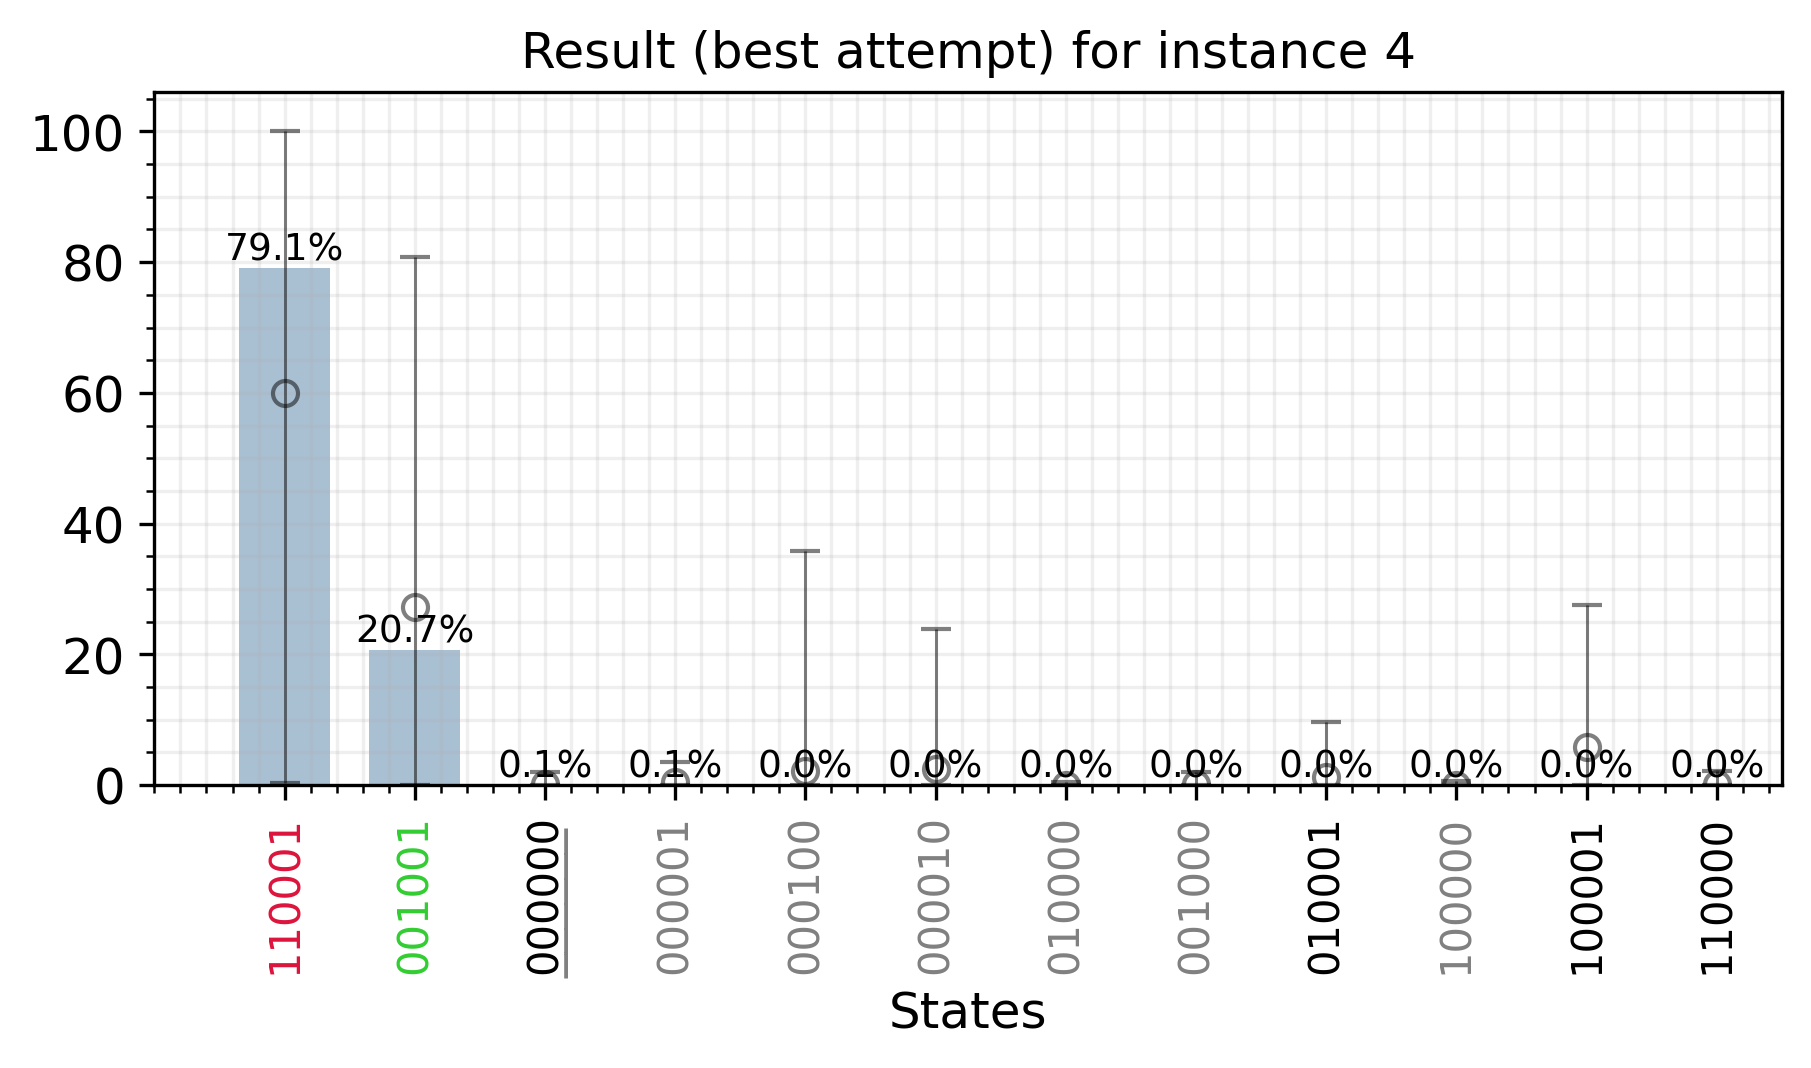

Result saved in:
random_parameters_2025-09-10@08h23m37s/dim6_mail4_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-10@08h23m37s/dim6_mail4_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 51.62534720102946 minutes.
1.0 5
**************************************************
Instance 5 with h = 1.0

U, subsets, EXACT_COVERS, MEC {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} [{5, 6}, {1, 2, 4, 5, 7, 8, 9, 10, 11, 12}, {1, 2, 3, 4, 7, 8}, {9, 11}, {10, 12}, {10, 12, 5, 6}] ['001101', '101110'] ['001101']


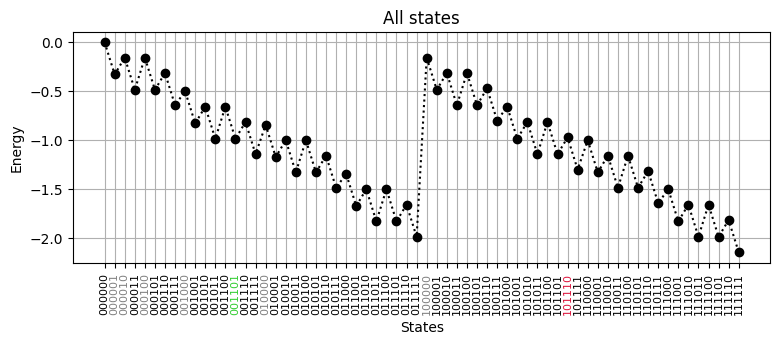

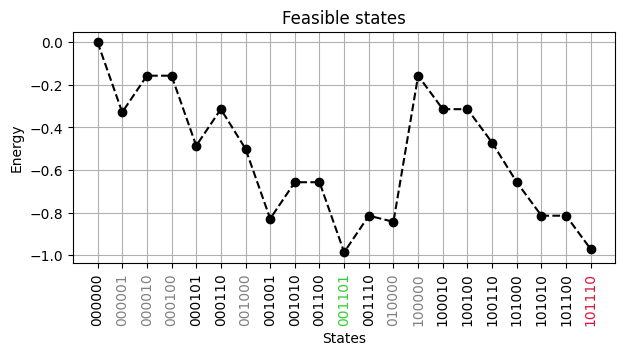

Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {5, 6}
  2: {1, 2, 4, 5, 7, 8, 9, 10, 11, 12}
  3: {1, 2, 3, 4, 7, 8}
  4: {9, 11}
  5: {10, 12}
  6: {10, 12, 5, 6}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
A = 1.1142857142857143
B = 0.04285714285714286
constant = -A + B = -1.0714285714285714

hamiltonian:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII'],
              coeffs=[0.07857143+0.j, 0.42142857+0.j, 0.25      +0.j, 0.07857143+0.j,
 0.07857143+0.j, 0.16428571+0.j])
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {5, 6}
  2: {1, 2, 4, 5, 7, 8, 9, 10, 11, 12}
  3: {1, 2, 3, 4, 7, 8}
  4: {9, 11}
  5: {10, 12}
  6: {10, 12, 5, 6}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
Mixing circuit created for instance 5 with 6 qubits.
Circuit dimension (QC_DIM): 10
Number of ancillas: 4
Number of control gates: 5
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {5, 6}
  2: {1, 2, 4, 5, 7, 8, 9, 10, 11, 1

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8707102371143728
E_min = result.fun = 0.2007183343141986

Optimal parameters: betas, gammas = [np.float64(3.4496521801935653), np.float64(5.344560289262706), np.float64(2.4075280793106675), np.float64(1.9272609648798509)], [np.float64(8.228288492642301), np.float64(-9.942476797257143), np.float64(3.652337919605616), np.float64(-4.482018959521086)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_2of50
7   001001              390
10  001101              311
18  101010              112
20  101110              107
12  010000               27
11  001110               23
15  100100               14
8   001010               11
16  100110                4
3   000100                4
13  100000                4
9   001100                3
0   000000                3
17  101000                3
2   000010                2
4   000101                1
1   000001                1
6   001000                1
5   000110                1
14  100010    

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8273773392191851
E_min = result.fun = 0.24405123220938632

Optimal parameters: betas, gammas = [np.float64(2.9109379407486373), np.float64(1.3323122169735389), np.float64(4.677427298046338), np.float64(3.6394134882060145)], [np.float64(-0.9475792786625357), np.float64(0.23681467473691506), np.float64(-5.777363853578577), np.float64(-7.171986551569665)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_8of50
2   001001              769
13  101010              114
7   010000               47
5   001101               39
12  101000               16
3   001010               13
14  101110               12
1   001000                3
6   001110                3
9   100010                2
0   000110                2
4   001100                1
8   100000                1
10  100100                1
11  100110                1

---------- 9/50 random_attempts -----------

pars_0 = [5.820439288919399, 5.487220506116451, 0.8489676764732986, 5.25921

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9714285714324769
E_min = result.fun = 0.09999999999609453

Optimal parameters: betas, gammas = [np.float64(3.1415926373249974), np.float64(0.051009114419634), np.float64(6.232177514001032), np.float64(6.283184124172323)], [np.float64(9.968412764638217), np.float64(2.1786230194360687), np.float64(2.2443637718459666e-05), np.float64(-0.7888837177482937)]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_10of50
0  101110              1024

---------- 11/50 random_attempts -----------

pars_0 = [1.4617978292619853, 4.516561213711915, 1.108430508248342, 1.9698812054563757, -1.6850935756287218, -4.521653938037845, 2.7024655053603333, -0.10628219614060974]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9124138211843387
E_min = result.fun = 0.15901475024423276

Optimal parameters: betas, gammas = [np.float64(1.5426287848066238), np.float64(4.630458604113916), np.float64(0.938915900321413), np.float64(2.2407582765612393)], [np.float64(-4.4126369611252), np.float64(0.05234064236477543), np.float64(3.5517729469189403), np.float64(0.16617179619052116)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_11of50
14  101110               750
6   001100               141
8   001110                61
7   001101                30
9   010000                22
4   000110                 4
13  101100                 4
12  100100                 3
3   000100                 2
5   001010                 2
2   000010                 1
1   000001                 1
0   000000                 1
10  100000                 1
11  100010                 1

---------- 12/50 random_attempts -----------

pars_0 = [4.473027429138681, 0.1958618553544799, 5.0706187932

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9467094325227994
E_min = result.fun = 0.12471913890577202

Optimal parameters: betas, gammas = [np.float64(1.2453207471561356), np.float64(2.7854605123714773), np.float64(3.2525567052983266), np.float64(1.9557904385832368)], [np.float64(-8.87540346061656), np.float64(-9.064650193634968), np.float64(0.7160166478958487), np.float64(9.818980210694715)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_17of50
9   001101               469
18  101110               434
17  101100                39
10  010000                19
8   001100                18
4   000110                 9
15  101000                 7
16  101010                 4
12  100010                 4
1   000001                 4
7   001010                 4
5   001000                 2
13  100100                 2
6   001001                 2
3   000101                 2
14  100110                 2
0   000000                 1
2   000100                 1
11  100000           

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8524965499505088
E_min = result.fun = 0.21893202147806262

Optimal parameters: betas, gammas = [np.float64(3.6894113795975114), np.float64(5.676634783982282), np.float64(4.890006008073572), np.float64(1.742768532901933)], [np.float64(0.5834996284392493), np.float64(7.166706452600915), np.float64(1.9205532204931548), np.float64(9.995976620948777)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_27of50
19  101110               278
9   001101               171
7   001001               136
11  010000               105
17  101010               104
18  101100                63
8   001100                53
16  101000                39
10  001110                13
5   000110                11
6   001000                10
4   000101                 8
13  100010                 8
1   000001                 7
14  100100                 5
2   000010                 4
15  100110                 3
12  100000                 3
0   000000              

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8750938642949622
E_min = result.fun = 0.1963347071336092

Optimal parameters: betas, gammas = [np.float64(4.530329987104112), np.float64(2.8492083840619387), np.float64(2.041218824164758), np.float64(2.6793647917816155)], [np.float64(-9.516815851367781), np.float64(-9.175584645968364), np.float64(9.995903498597288), np.float64(1.0375732171717251)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_32of50
18  101110               503
11  010000               209
17  101100               209
9   001101                36
8   001010                12
0   000000                12
16  101010                 5
6   001000                 5
10  001110                 5
13  100100                 4
1   000001                 4
15  101000                 4
14  100110                 3
7   001001                 3
3   000100                 3
2   000010                 2
4   000101                 2
12  100010                 2
5   000110             

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9705551381198749
E_min = result.fun = 0.10087343330869641

Optimal parameters: betas, gammas = [np.float64(0.0), np.float64(6.237109693875674), np.float64(3.1247912852247097), np.float64(0.006614506004226403)], [np.float64(0.8360831331717913), np.float64(-4.901342911960837), np.float64(2.1014991113569823), np.float64(2.8368966850088992)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_34of50
0  101110              1024

---------- 35/50 random_attempts -----------

pars_0 = [0.28789495274663046, 3.8004740595476423, 5.3607887002609145, 0.13374157287161673, -9.247236340417924, -7.293389187749408, 0.5776327962770491, -8.166072588105417]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
  

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8701764581651454
E_min = result.fun = 0.20125211326342596

Optimal parameters: betas, gammas = [np.float64(3.459706952830884), np.float64(5.3174118832461374), np.float64(2.4338569168832676), np.float64(1.9226441649740202)], [np.float64(-0.2544104225855026), np.float64(9.638625176156063), np.float64(-3.7274232973729298), np.float64(4.336792155269809)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_36of50
5   001001               389
8   001101               338
15  101010               104
17  101110                99
9   001110                23
10  010000                23
6   001010                10
14  100110                 9
13  100100                 7
0   000000                 3
1   000010                 3
11  100000                 3
7   001100                 3
4   001000                 3
12  100010                 2
2   000100                 2
16  101100                 2
3   000101                 1

---------- 37/50 ra

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9714341218354507
E_min = result.fun = 0.09999444959312061

Optimal parameters: betas, gammas = [np.float64(6.2800638876948796), np.float64(3.1444161690672052), np.float64(0.6721231749350933), np.float64(5.61145086437814)], [np.float64(-3.922414579235628), np.float64(9.584611789937409), np.float64(-1.422070625324897), np.float64(0.011623666722570297)]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_39of50
1  101110              1023
0  001101                 1

---------- 40/50 random_attempts -----------

pars_0 = [2.573110714749717, 3.7029367006521063, 1.8655706982549523, 1.9741764090913596, -9.38093367526467, -1.8957015739557281, -7.934158177586058, 0.901830764169846]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9069122397743432
E_min = result.fun = 0.16451633165422822

Optimal parameters: betas, gammas = [np.float64(1.5389789960979359), np.float64(4.841729105973596), np.float64(0.631459799515206), np.float64(2.6179945232467308)], [np.float64(8.92987171263216), np.float64(0.017739617536139188), np.float64(-3.7865133320678668), np.float64(0.4904635046352257)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_40of50
15  101110               738
6   001110               112
4   001100                77
7   010000                33
14  101100                22
5   001101                13
13  101010                11
10  100100                 6
9   100010                 2
11  100110                 2
3   001010                 2
2   001000                 2
1   000100                 1
0   000000                 1
8   100000                 1
12  101000                 1

---------- 41/50 random_attempts -----------

pars_0 = [5.499478202972876, 5.

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9714262571706478
E_min = result.fun = 0.10000231425792364

Optimal parameters: betas, gammas = [np.float64(3.147441594648825), np.float64(0.7206796232930519), np.float64(0.0016150825302389587), np.float64(5.562826629927017)], [np.float64(1.1670361807143843), np.float64(-3.5515898422740477), np.float64(-1.4617763041208232), np.float64(1.4824487699647664)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_47of50
1  101110              1023
0  001101                 1

---------- 48/50 random_attempts -----------

pars_0 = [3.152473494511244, 5.193958338607039, 2.8050637709789794, 3.7869059895455806, -6.034403350565393, 6.915979857419202, -0.37578975157118677, -9.331061968873048]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

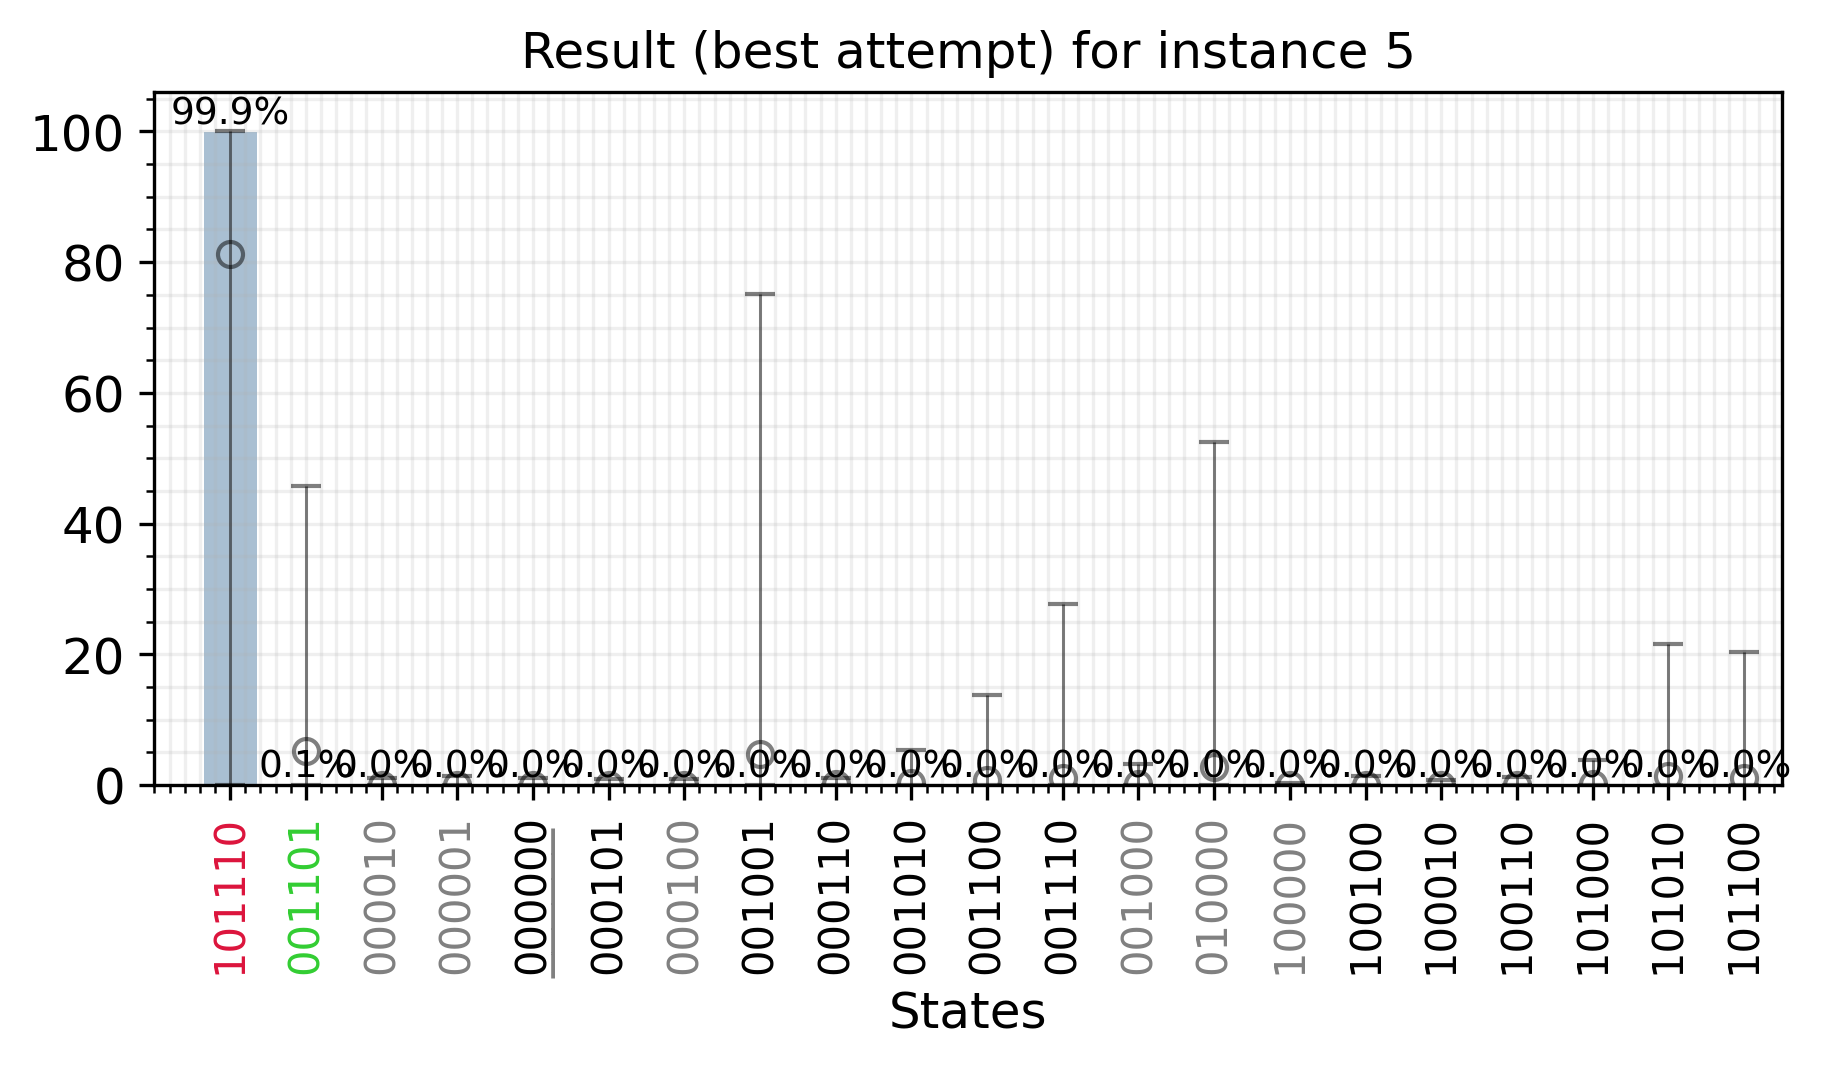

Result saved in:
random_parameters_2025-09-10@08h23m37s/dim6_mail5_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-10@08h23m37s/dim6_mail5_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 31.2263827085495 minutes.
1.0 6
**************************************************
Instance 6 with h = 1.0

U, subsets, EXACT_COVERS, MEC {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} [{1, 2, 4, 5, 7, 8, 9, 10, 11, 12}, {1, 3, 6}, {1, 3, 6, 7, 10, 11}, {1, 2, 3, 4, 5, 7, 9, 10, 11, 12}, {10, 11, 7}, {2, 4, 5, 8, 9, 12}] ['001001', '010011'] ['001001']


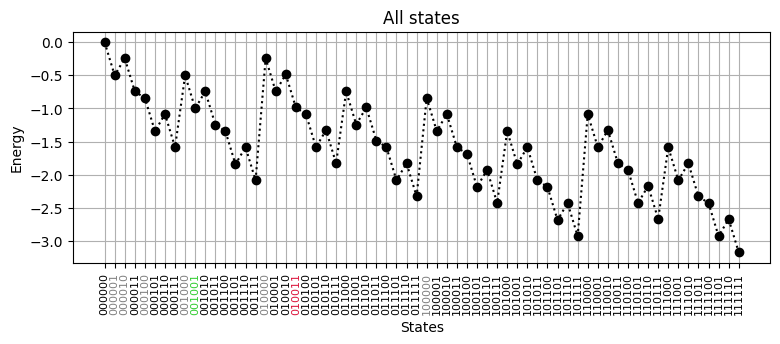

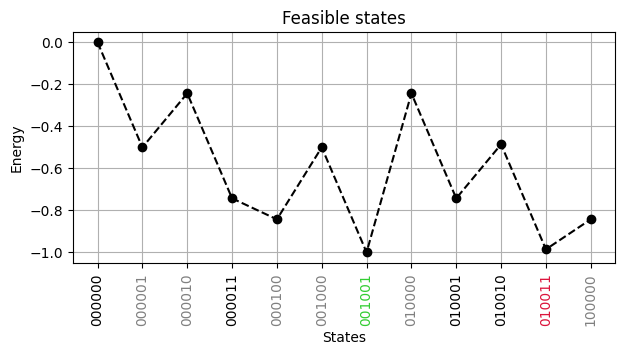

Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {1, 2, 4, 5, 7, 8, 9, 10, 11, 12}
  2: {1, 3, 6}
  3: {1, 3, 6, 7, 10, 11}
  4: {1, 2, 3, 4, 5, 7, 9, 10, 11, 12}
  5: {10, 11, 7}
  6: {2, 4, 5, 8, 9, 12}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
A = 1.6285714285714286
B = 0.04285714285714286
constant = -A + B = -1.5857142857142856

hamiltonian:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII'],
              coeffs=[0.42142857+0.j, 0.12142857+0.j, 0.25      +0.j, 0.42142857+0.j,
 0.12142857+0.j, 0.25      +0.j])
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {1, 2, 4, 5, 7, 8, 9, 10, 11, 12}
  2: {1, 3, 6}
  3: {1, 3, 6, 7, 10, 11}
  4: {1, 2, 3, 4, 5, 7, 9, 10, 11, 12}
  5: {10, 11, 7}
  6: {2, 4, 5, 8, 9, 12}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
Mixing circuit created for instance 6 with 6 qubits.
Circuit dimension (QC_DIM): 10
Number of ancillas: 4
Number of control gates: 5
Universe: {1, 2, 3, 4, 5, 6, 

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.866257672385994
E_min = result.fun = 0.7194566133282916

Optimal parameters: betas, gammas = [np.float64(1.9980758314025016), np.float64(0.42363835667728167), np.float64(0.26693648881838145), np.float64(6.042355233001045)], [np.float64(-5.308967890790194), np.float64(0.4160327575706833), np.float64(-3.967969924886765), np.float64(-2.9807525455211277)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_10of50
9  100000               790
8  010011               147
5  001001                40
7  010010                13
3  000100                10
2  000011                 7
6  010001                 7
1  000010                 4
0  000001                 3
4  001000                 3

---------- 11/50 random_attempts -----------

pars_0 = [3.2001798190797532, 1.909883124096328, 5.266055010176044, 4.728585849405922, 5.932380410450706, -3.7960219788612153, 6.437900875375305, 0.38199364915414424]
bnds = [(0, 6.283185307179586), (0, 6.2831853071

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9021501882340959
E_min = result.fun = 0.6835640974801898

Optimal parameters: betas, gammas = [np.float64(0.36061705493379814), np.float64(5.608256658291689), np.float64(6.283185307179586), np.float64(2.2146814503966183)], [np.float64(1.9353981063951893), np.float64(4.3874672111979915), np.float64(6.467984875024417), np.float64(0.29899199051663866)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_12of50
5  001001               406
7  010011               232
6  010001               188
8  100000               103
3  000100                35
0  000001                25
2  000011                17
1  000010                15
4  001000                 3

---------- 13/50 random_attempts -----------

pars_0 = [5.854900849293334, 6.224395211763504, 6.1784920414494175, 1.9192153815637636, -3.4991761888018313, -3.397385574338469, 2.1669627547675345, -3.6649107729649533]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.2831853071795

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.864284313481039
E_min = result.fun = 0.7214299722332467

Optimal parameters: betas, gammas = [np.float64(5.945668045523901), np.float64(4.051254672700502), np.float64(0.3818561008502823), np.float64(6.150916406964122)], [np.float64(-4.313000503110906), np.float64(-6.467973814263498), np.float64(6.467966155098745), np.float64(-0.32457708120574713)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_14of50
10  100000               595
9   010011               246
2   000011                50
5   001001                43
3   000100                38
7   010001                34
8   010010                 9
4   001000                 3
0   000001                 2
1   000010                 2
6   010000                 2

---------- 15/50 random_attempts -----------

pars_0 = [2.6165679511795608, 4.963691623773072, 6.007941024543399, 6.225769142072015, 2.1093351140028096, -2.4297671073540306, 0.5513949490228534, 2.5277025356823026]
bnds = [(0,

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.857888402006684
E_min = result.fun = 0.7278258837076016

Optimal parameters: betas, gammas = [np.float64(5.538655872484154), np.float64(1.6276310594456658), np.float64(6.283163651431247), np.float64(0.19408653422743394)], [np.float64(6.467967799726294), np.float64(6.467853602804872), np.float64(6.46772499128122), np.float64(6.467975830517046)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_18of50
10  100000               450
5   001001               218
3   000100               133
7   010001                85
9   010011                56
2   000011                29
0   000001                24
4   001000                14
1   000010                 9
8   010010                 5
6   010000                 1

---------- 19/50 random_attempts -----------

pars_0 = [1.0399910246118567, 3.1329295462012836, 4.727258331919065, 1.7210706356405763, 5.058261419118918, -0.7386864876921599, -5.403341376833516, 6.427045204788235]
bnds = [(0, 6.2

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8630842942125249
E_min = result.fun = 0.7226299915017608

Optimal parameters: betas, gammas = [np.float64(1.9234763311465612), np.float64(0.43270515318007297), np.float64(0.5247731742413684), np.float64(0.22632144524661374)], [np.float64(-6.452584387207978), np.float64(2.0845723411086343), np.float64(-4.183646951649298), np.float64(2.7381461390392428)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_23of50
7  100000               693
6  010011               207
4  001001                45
2  000011                30
5  010010                27
3  000100                11
0  000001                 9
1  000010                 2

---------- 24/50 random_attempts -----------

pars_0 = [6.002459222284698, 6.146510482327622, 1.4272279798613938, 2.230484747106193, 0.6665488682335798, 3.3642423549718865, -4.001464170594306, -5.902438299106027]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586),

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9353840506424821
E_min = result.fun = 0.6503302350718035

Optimal parameters: betas, gammas = [np.float64(6.038651092287214), np.float64(5.1405883573609765), np.float64(1.1082165120782683), np.float64(2.6089666849175623)], [np.float64(-1.4488053345096152), np.float64(5.541215909320881), np.float64(-0.8352731714343814), np.float64(-3.6987843531605327)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_24of50
8  010011               660
9  100000               194
4  001001                84
2  000011                26
3  000100                24
1  000001                14
6  010001                12
5  010000                 5
7  010010                 3
0  000000                 2

---------- 25/50 random_attempts -----------

pars_0 = [4.679939393525727, 2.976096446045225, 0.04361820647792089, 2.131272351472288, 5.720784553560679, 2.719321490761131, -3.2993928682302998, 1.0550915658416482]
bnds = [(0, 6.283185307179586), (0, 6.2831853071

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.903982025844765
E_min = result.fun = 0.6817322598695207

Optimal parameters: betas, gammas = [np.float64(2.19935087715111), np.float64(3.598884070408368), np.float64(2.0021059032831734), np.float64(2.50077690785338)], [np.float64(2.5032881544839585), np.float64(0.22138933660927945), np.float64(0.2938905027702038), np.float64(-6.467973934529888)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_27of50
9   010011               454
10  100000               276
5   001001               136
7   010001                47
3   000100                42
2   000011                24
1   000010                14
8   010010                11
0   000001                 9
4   001000                 8
6   010000                 3

---------- 28/50 random_attempts -----------

pars_0 = [5.394149893625148, 5.5160646076836395, 1.975734710231482, 4.3769171372151, -1.4763924414236032, -1.3610745745471489, 2.8455168685782626, -5.914731335248734]
bnds = [(0, 6.

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9199551450153498
E_min = result.fun = 0.6657591406989358

Optimal parameters: betas, gammas = [np.float64(4.935997923074037), np.float64(0.9921312934590711), np.float64(6.283185307179586), np.float64(3.459753675614528)], [np.float64(-5.221224915487973), np.float64(0.33867914284819783), np.float64(6.04058462410716), np.float64(-2.435385208230221)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_31of50
10  010011               610
11  100000               193
4   000100                73
6   001001                68
3   000011                34
9   010010                27
8   010001                 9
2   000010                 3
5   001000                 3
1   000001                 2
0   000000                 1
7   010000                 1

---------- 32/50 random_attempts -----------

pars_0 = [1.1441690873802681, 6.121400231374403, 3.752604361255103, 2.7115076011024084, 5.487973240957591, 1.0390053911732187, 5.020990896872566, 6.377

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8585454884395165
E_min = result.fun = 0.7271687972747691

Optimal parameters: betas, gammas = [np.float64(0.0666545390388106), np.float64(6.283185306560252), np.float64(6.051426419643089), np.float64(3.831582541109567)], [np.float64(-6.46263759132442), np.float64(1.507839772760085), np.float64(6.467984875019598), np.float64(6.467984839269681)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_32of50
10  100000               762
9   010011               158
4   000100                31
7   010001                29
6   001001                17
8   010010                11
3   000011                 6
1   000001                 5
2   000010                 3
0   000000                 1
5   001000                 1

---------- 33/50 random_attempts -----------

pars_0 = [4.62351484078474, 2.085706482095774, 1.8354145247518516, 5.169238296447742, 0.988920558479367, 5.539824487319289, 1.1287255843415291, 3.088610413512648]
bnds = [(0, 6.283185

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9378121526177154
E_min = result.fun = 0.6479021330965702

Optimal parameters: betas, gammas = [np.float64(0.9426987041673969), np.float64(1.1239331091732505), np.float64(1.6981286816207646), np.float64(3.178691802905449e-13)], [np.float64(-2.2063547539190087), np.float64(3.9007939376857674), np.float64(-2.039548979243143), np.float64(-2.7500811040299467)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_42of50
8  010011               795
3  000100               100
9  100000                41
2  000011                29
7  010010                26
4  001001                12
6  010001                 9
1  000001                 5
5  010000                 4
0  000000                 3

---------- 43/50 random_attempts -----------

pars_0 = [4.565467562794393, 3.627251259168494, 5.840537421774018, 3.529445404486849, 3.5866974635571145, -1.098690156471985, 3.2621039964570118, -5.756485622215924]
bnds = [(0, 6.283185307179586), (0, 6.2831853

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8772179049203919
E_min = result.fun = 0.7084963807938938

Optimal parameters: betas, gammas = [np.float64(0.34033732088923374), np.float64(6.055338577934762), np.float64(3.8596307099108387), np.float64(6.233263046934383)], [np.float64(-3.159320255557189), np.float64(4.225384093887216), np.float64(6.4676353839930485), np.float64(4.511733802463715)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_49of50
9  100000               501
8  010011               414
2  000100                44
3  001000                33
5  010000                10
4  001001                10
1  000011                 5
7  010010                 3
6  010001                 3
0  000010                 1

---------- 50/50 random_attempts -----------

pars_0 = [4.929419618187293, 4.236940053172743, 1.992492904363932, 1.84510623466557, -3.001373720345525, -2.224075721411344, -3.766898146351318, -5.827006771632384]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586)

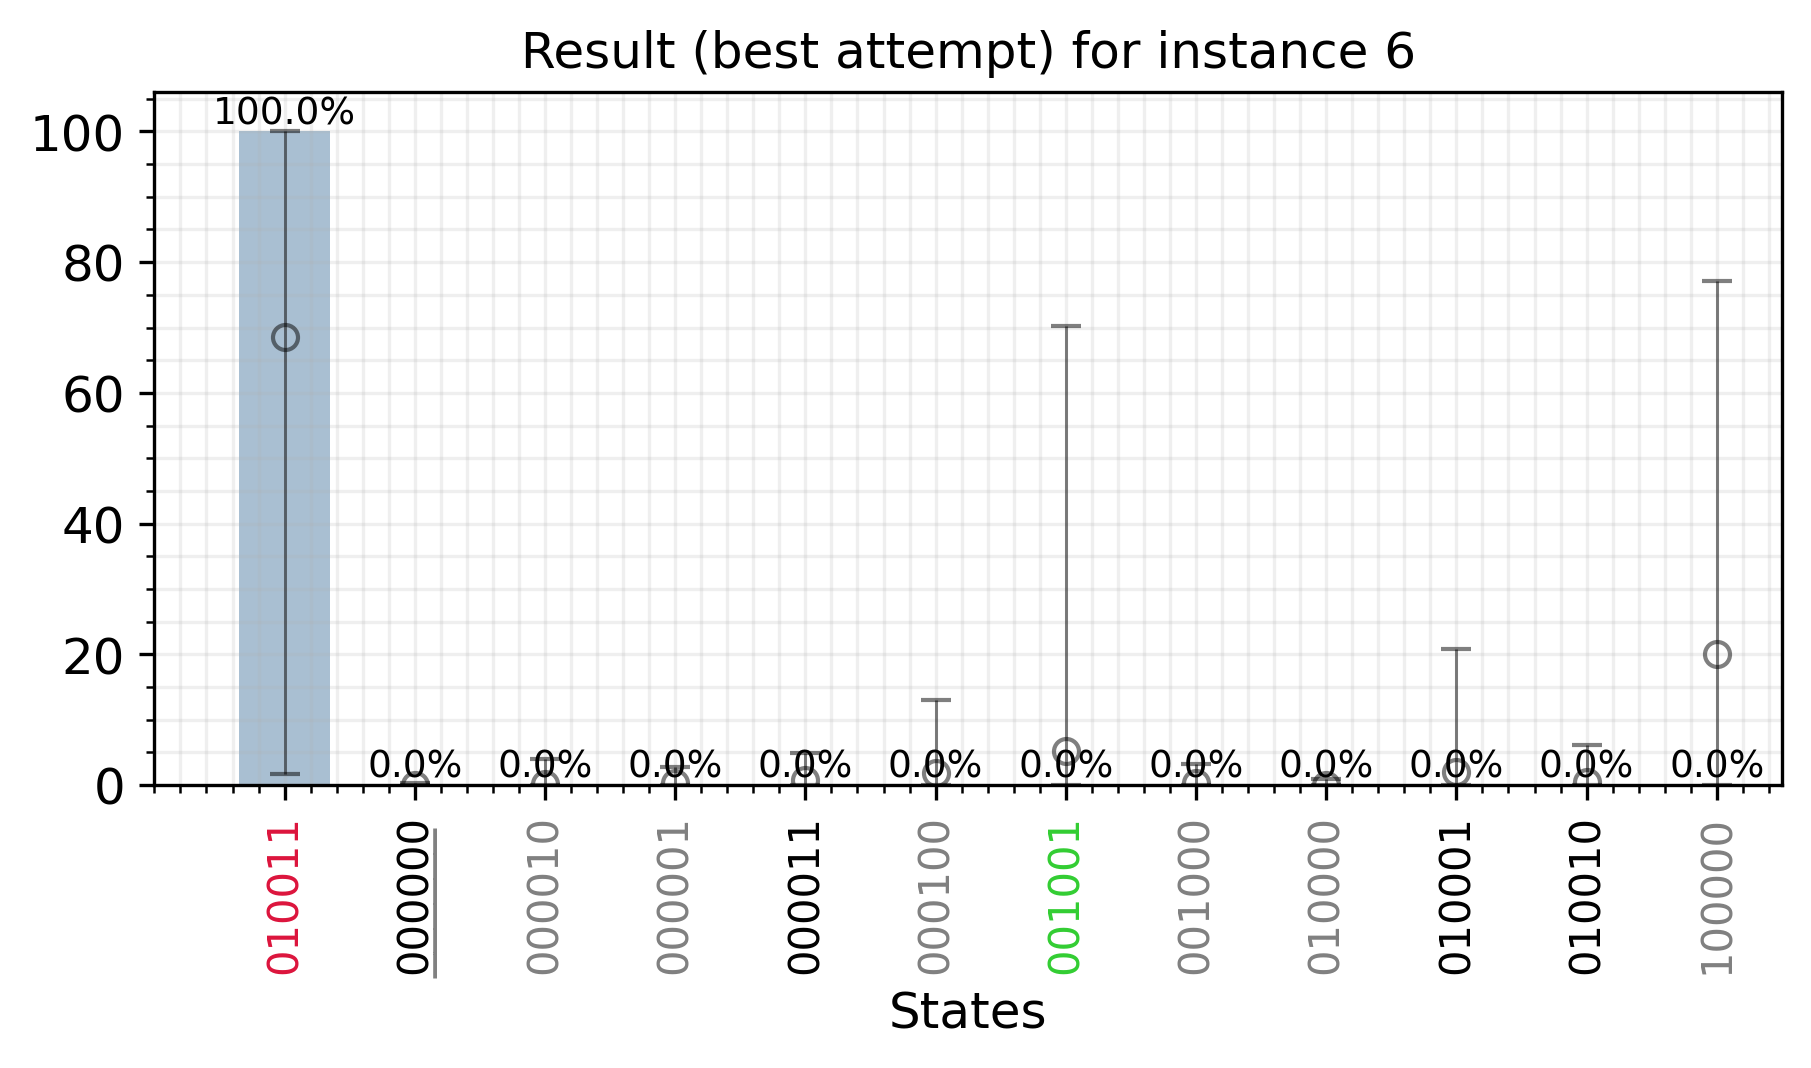

Result saved in:
random_parameters_2025-09-10@08h23m37s/dim6_mail6_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781].csv
random_parameters_2025-09-10@08h23m37s/dim6_mail6_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781]_data.txt

TOTAL ELAPSED TIME: 45.58126825094223 minutes.
1.0 7
**************************************************
Instance 7 with h = 1.0

U, subsets, EXACT_COVERS, MEC {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} [{1, 3, 8, 9, 10, 12}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 12}, {2, 11, 6, 7}, {9, 10}, {4, 5}, {8, 1, 3, 12}] ['001111', '101010'] ['101010']


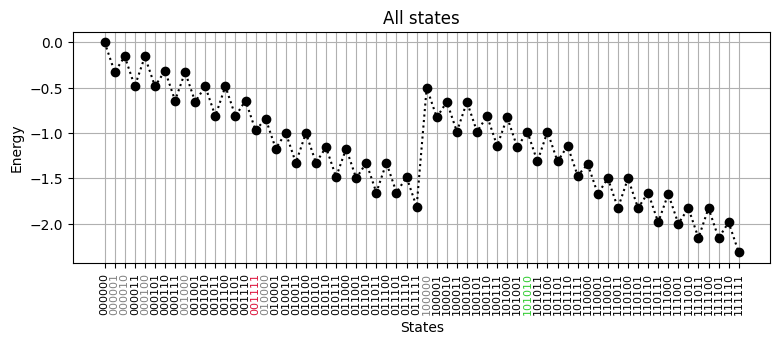

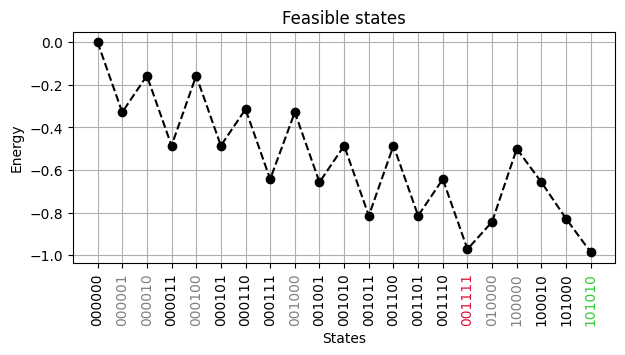

Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {1, 3, 8, 9, 10, 12}
  2: {1, 2, 3, 4, 5, 6, 7, 8, 9, 12}
  3: {2, 11, 6, 7}
  4: {9, 10}
  5: {4, 5}
  6: {8, 1, 3, 12}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
A = 1.2
B = 0.04285714285714286
constant = -A + B = -1.157142857142857

hamiltonian:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII'],
              coeffs=[0.25      +0.j, 0.42142857+0.j, 0.16428571+0.j, 0.07857143+0.j,
 0.07857143+0.j, 0.16428571+0.j])
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {1, 3, 8, 9, 10, 12}
  2: {1, 2, 3, 4, 5, 6, 7, 8, 9, 12}
  3: {2, 11, 6, 7}
  4: {9, 10}
  5: {4, 5}
  6: {8, 1, 3, 12}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
Mixing circuit created for instance 7 with 6 qubits.
Circuit dimension (QC_DIM): 10
Number of ancillas: 4
Number of control gates: 5
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {1, 3, 8, 9, 10, 12}
  2: {1, 2, 3, 4, 5, 6, 7, 8, 

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9438042757167152
E_min = result.fun = 0.21333858142614182

Optimal parameters: betas, gammas = [np.float64(1.3349329755878985), np.float64(6.211825088899078), np.float64(5.034392262864166), np.float64(3.4522293170704716)], [np.float64(9.36001265295732), np.float64(6.652527609371887), np.float64(-6.841552274085553), np.float64(-6.189382984198845)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_2of50
14  101010              613
9   001111              217
10  010000              106
13  101000               33
8   001101               18
12  100010                9
2   000101                7
6   001010                7
11  100000                4
7   001011                3
3   000110                2
5   001001                2
4   000111                1
0   000011                1
1   000100                1

---------- 3/50 random_attempts -----------

pars_0 = [0.6673433231686031, 3.969871155012596, 3.617782428646554, 0.99712130278

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9857096502361594
E_min = result.fun = 0.1714332069066976

Optimal parameters: betas, gammas = [np.float64(3.1431903571273185), np.float64(6.105216665432508), np.float64(6.175252860945541), np.float64(0.2844543940300558)], [np.float64(-2.4429044950183876), np.float64(-4.1207116073301755), np.float64(0.3723876891550659), np.float64(-0.23758980788198863)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_15of50
0  101010              1024

---------- 16/50 random_attempts -----------

pars_0 = [0.8632544053211674, 3.566850526167651, 1.784209755349056, 1.4694701245198183, -6.981522395598638, -8.381386625997557, 7.086103803032785, -0.42966257795922225]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated succ

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.932928595091945
E_min = result.fun = 0.22421426205091194

Optimal parameters: betas, gammas = [np.float64(1.4857637196335105), np.float64(0.5440741177662283), np.float64(5.7490890611136685), np.float64(2.173480825406661)], [np.float64(-4.613403949405846), np.float64(-8.234675135571866), np.float64(1.6089079078519477), np.float64(7.154253445503938)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_18of50
12  001111               731
17  101010               156
9   001010                29
15  100010                24
11  001110                16
16  101000                15
8   001001                12
3   000011                12
13  010000                 6
2   000010                 5
4   000101                 5
10  001101                 4
14  100000                 3
7   001000                 2
1   000001                 1
0   000000                 1
6   000111                 1
5   000110                 1

---------- 19/50 rand

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9856572385407938
E_min = result.fun = 0.17148561860206324

Optimal parameters: betas, gammas = [np.float64(0.0), np.float64(3.1225382406602504), np.float64(6.283185307179586), np.float64(6.283185307179586)], [np.float64(-4.172898084682351), np.float64(6.892323658853437), np.float64(9.28814930668609), np.float64(4.23267293229719)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_22of50
1  101010              1023
0  010000                 1

---------- 23/50 random_attempts -----------

pars_0 = [2.9504316767663297, 5.690924631775346, 1.3885306652143323, 1.4876316140215797, 7.469834289698081, 7.033751364583207, -2.001508603426708, -0.38463010892991]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated su

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9857142857142824
E_min = result.fun = 0.1714285714285746

Optimal parameters: betas, gammas = [np.float64(0.0), np.float64(9.300069900738496e-08), np.float64(1.1793029182068773e-07), np.float64(3.1415925911778597)], [np.float64(-0.6245857377054618), np.float64(6.943881007302782), np.float64(-8.176659143441142), np.float64(5.4787691346299425)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_26of50
0  101010              1024

---------- 27/50 random_attempts -----------

pars_0 = [4.670162301323962, 0.9038415480881469, 1.2744882529924941, 0.5755973358786801, -1.8537240143029443, 0.22695383073187259, -6.010835912617988, 5.073397548070647]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.

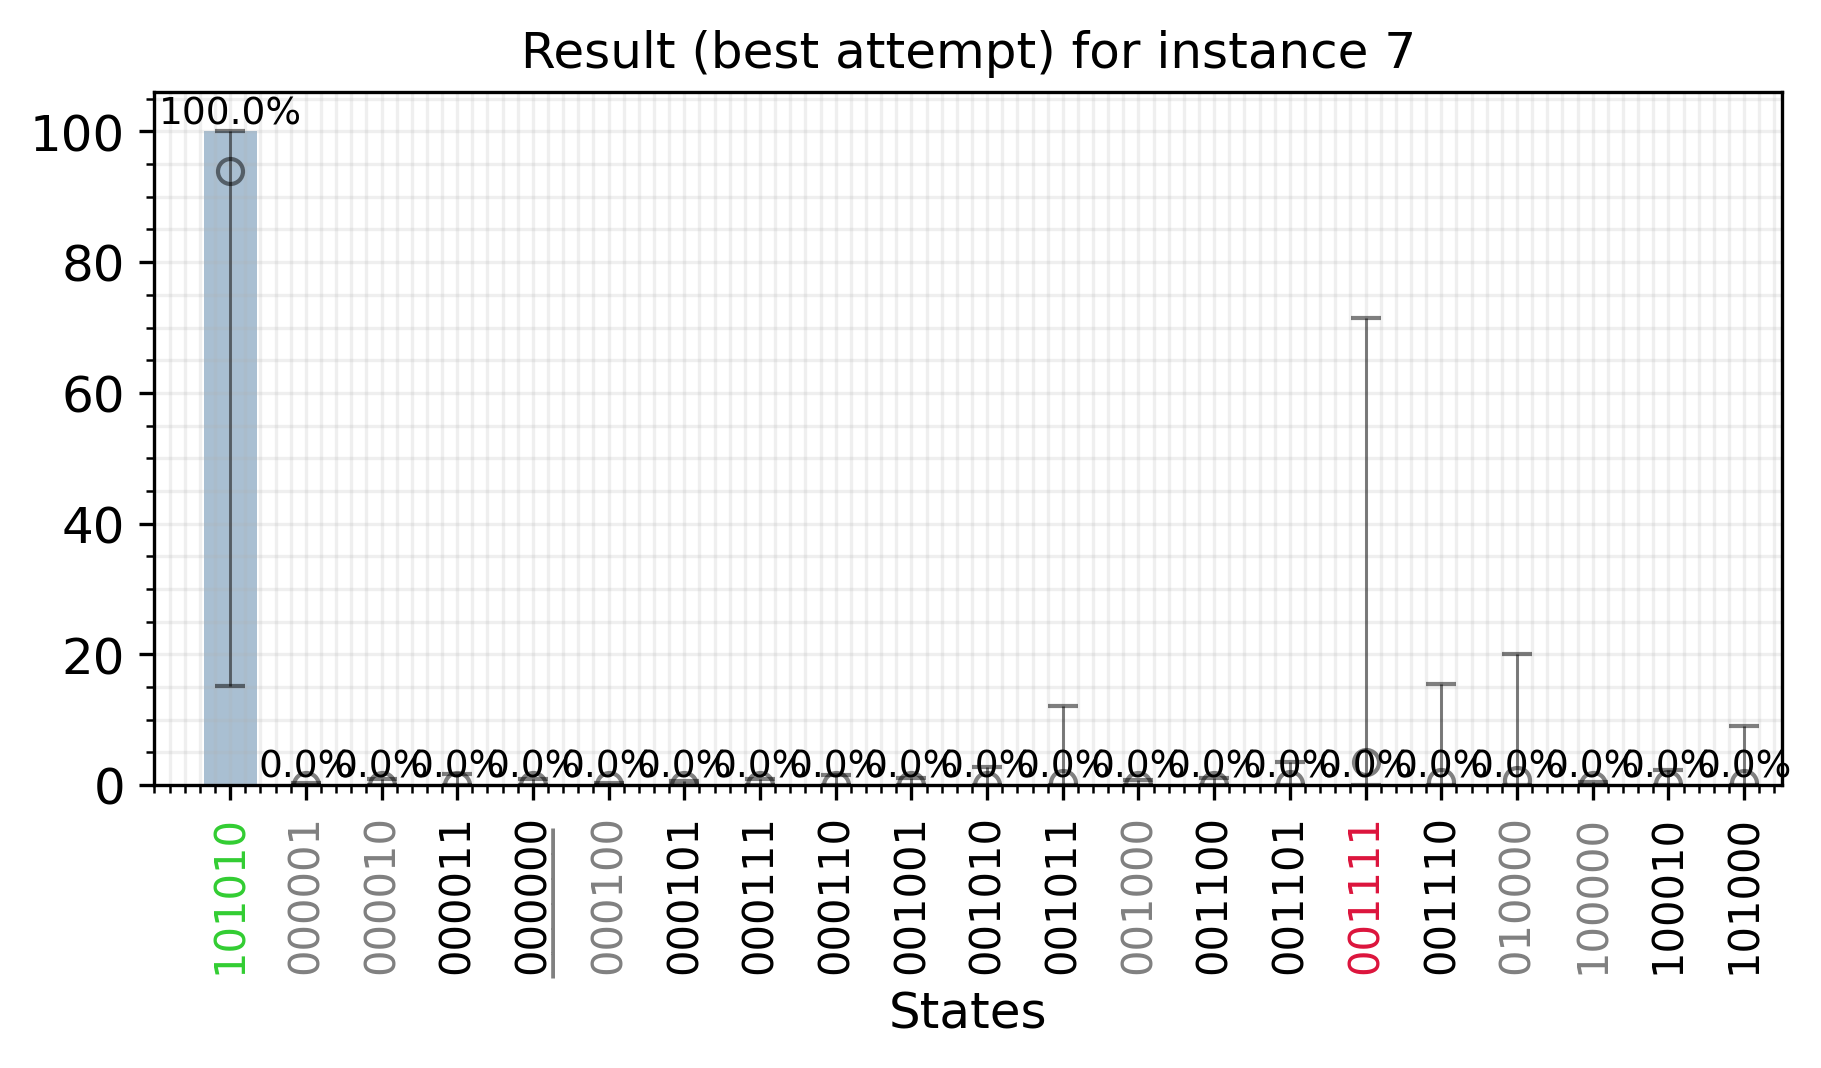

Result saved in:
random_parameters_2025-09-10@08h23m37s/dim6_mail7_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-10@08h23m37s/dim6_mail7_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 28.404550862312316 minutes.
1.0 8
**************************************************
Instance 8 with h = 1.0

U, subsets, EXACT_COVERS, MEC {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} [{2, 4, 7, 11, 12}, {1, 2, 4, 5, 6, 7, 10, 11, 12}, {8, 9, 3}, {1, 3, 4, 5, 6, 8, 9, 10, 11, 12}, {1, 2, 3, 4, 5, 6, 7, 10, 11, 12}, {1, 10, 5, 6}] ['011000', '101001'] ['011000']


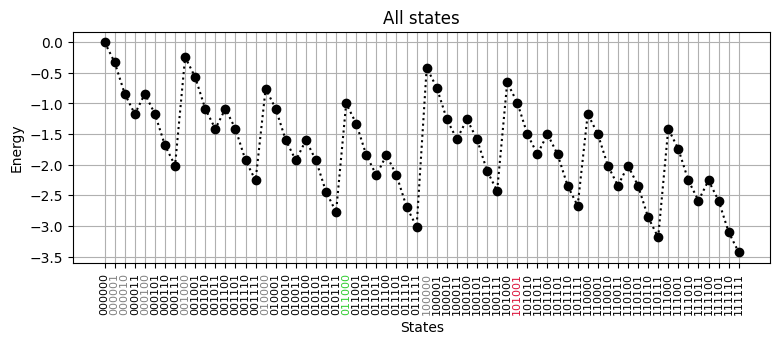

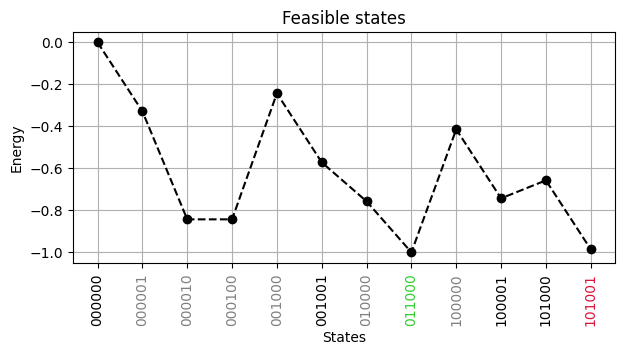

Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {2, 4, 7, 11, 12}
  2: {1, 2, 4, 5, 6, 7, 10, 11, 12}
  3: {8, 9, 3}
  4: {1, 3, 4, 5, 6, 8, 9, 10, 11, 12}
  5: {1, 2, 3, 4, 5, 6, 7, 10, 11, 12}
  6: {1, 10, 5, 6}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
A = 1.7571428571428571
B = 0.04285714285714286
constant = -A + B = -1.7142857142857142

hamiltonian:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII'],
              coeffs=[0.20714286+0.j, 0.37857143+0.j, 0.12142857+0.j, 0.42142857+0.j,
 0.42142857+0.j, 0.16428571+0.j])
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {2, 4, 7, 11, 12}
  2: {1, 2, 4, 5, 6, 7, 10, 11, 12}
  3: {8, 9, 3}
  4: {1, 3, 4, 5, 6, 8, 9, 10, 11, 12}
  5: {1, 2, 3, 4, 5, 6, 7, 10, 11, 12}
  6: {1, 10, 5, 6}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
Mixing circuit created for instance 8 with 6 qubits.
Circuit dimension (QC_DIM): 10
Number of ancillas: 4
Number of control gates: 5
Universe:

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9857142857142598
E_min = result.fun = 0.7285714285714544

Optimal parameters: betas, gammas = [np.float64(3.1415924826460184), np.float64(0.029643353849998), np.float64(6.253542274325362), np.float64(7.414418273527325e-07)], [np.float64(-2.35251055614805), np.float64(5.711846256803101), np.float64(-3.800669689130339e-05), np.float64(-6.467984875037807)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_17of50
0  101001              1024

---------- 18/50 random_attempts -----------

pars_0 = [3.8422727682854294, 3.058004364948983, 0.10571064561651597, 5.377188409741107, 3.6358896385193544, 0.026564820543444334, 2.960893624153461, -5.102413235237788]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781)]

Optimization terminated successful

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8121427241774684
E_min = result.fun = 0.9021429901082458

Optimal parameters: betas, gammas = [np.float64(1.579091406158443), np.float64(3.548035068971492), np.float64(5.248299372795856), np.float64(2.7937870794047104)], [np.float64(3.4040982946417415), np.float64(1.6430258484929565), np.float64(6.46780470517535), np.float64(-6.467908263264837)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_35of50
10  101001               305
3   000100               214
9   100001               129
6   010000               122
5   001001                86
2   000010                78
8   100000                57
7   011000                20
4   001000                 6
1   000001                 4
0   000000                 3

---------- 36/50 random_attempts -----------

pars_0 = [5.36524860953518, 5.927050927338242, 6.139836091657865, 4.049076350235672, -1.2036009805600223, 4.174818150633262, -1.9176654832720006, 0.47567258446233573]
bnds = [(0, 6.

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9466788091283883
E_min = result.fun = 0.7676069051573259

Optimal parameters: betas, gammas = [np.float64(5.336059965004621), np.float64(1.9377943780736753), np.float64(5.403372316431101), np.float64(2.675266708972404)], [np.float64(6.467984875037729), np.float64(-0.4191840708680786), np.float64(-0.630154639046283), np.float64(0.1811968088105944)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_44of50
6  011000               763
1  000010               171
5  010000                47
8  101000                23
7  100000                 8
9  101001                 4
3  001000                 3
4  001001                 2
2  000100                 2
0  000000                 1

---------- 45/50 random_attempts -----------

pars_0 = [3.759541989566014, 5.819099323240147, 2.771336459748753, 4.265032124665966, -3.2635820119603274, 5.574383282618872, -1.616047765107961, -4.188405509197357]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586

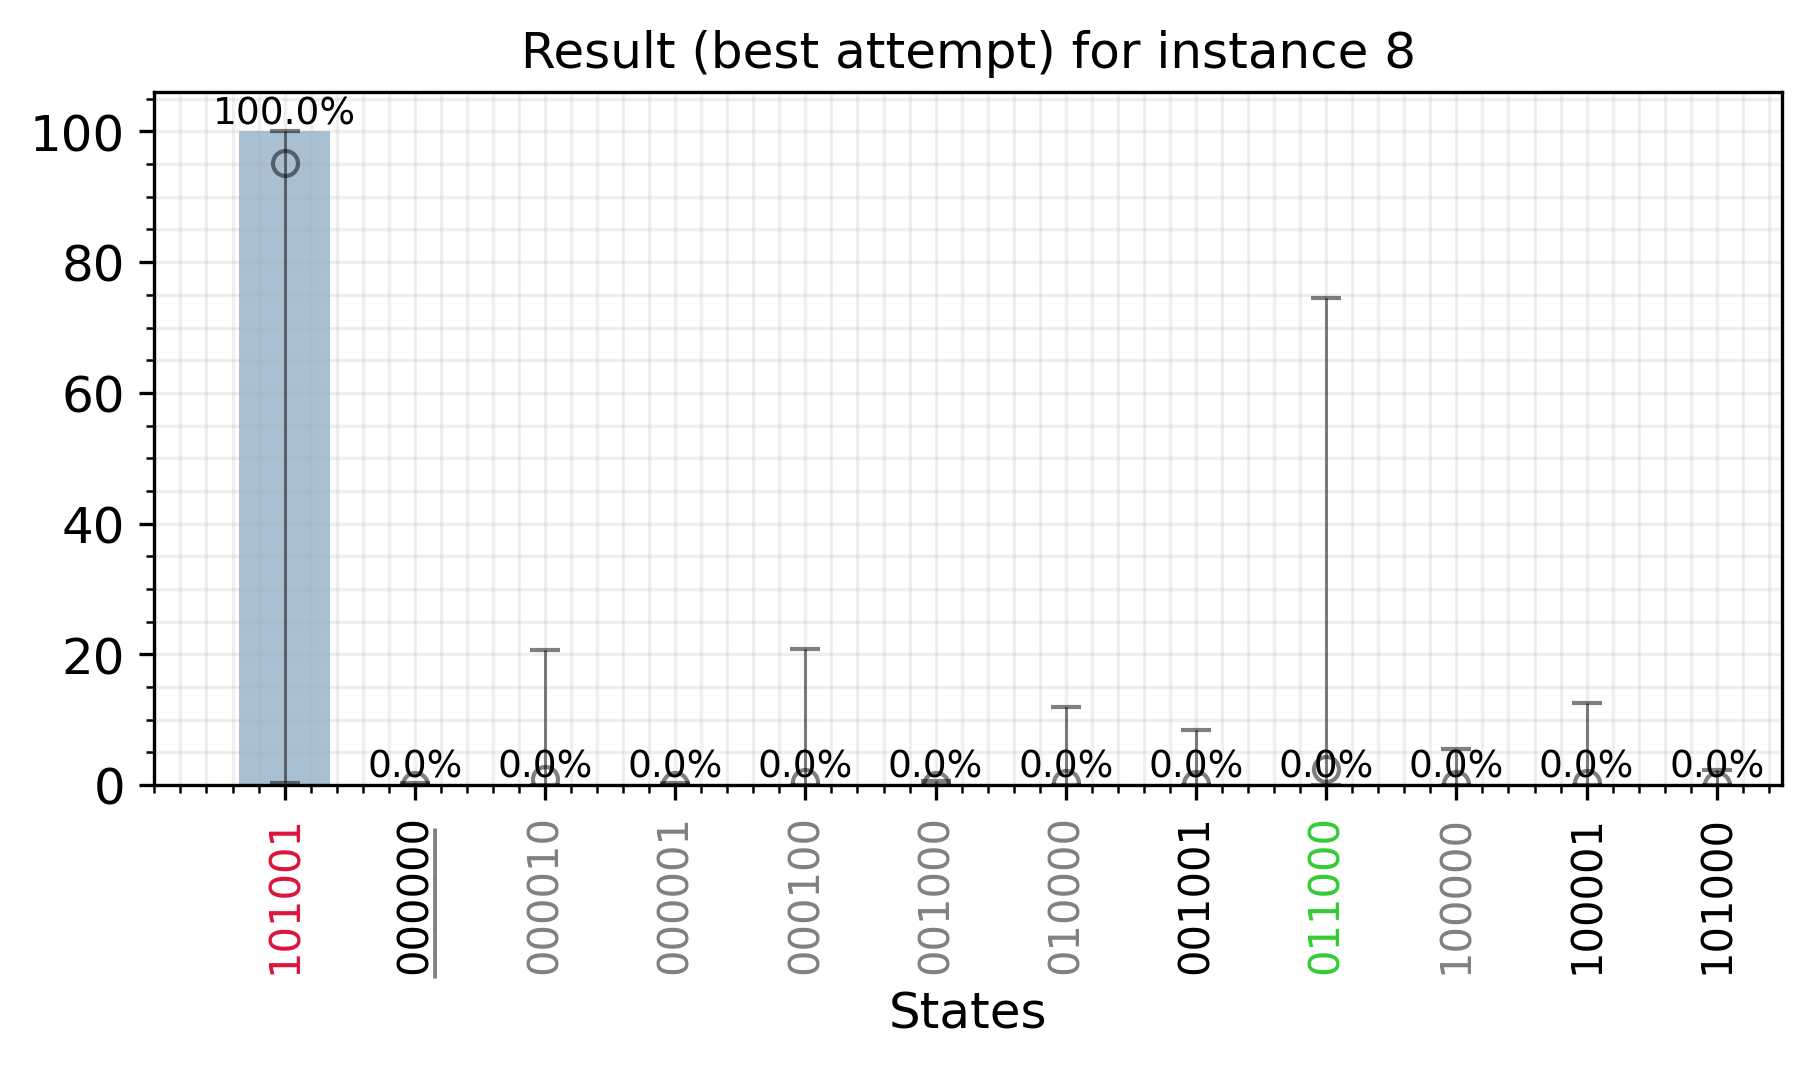

Result saved in:
random_parameters_2025-09-10@08h23m37s/dim6_mail8_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781].csv
random_parameters_2025-09-10@08h23m37s/dim6_mail8_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781]_data.txt

TOTAL ELAPSED TIME: 33.46414158741633 minutes.
1.0 9
**************************************************
Instance 9 with h = 1.0

U, subsets, EXACT_COVERS, MEC {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} [{8, 9, 10, 11}, {1, 2, 3, 4, 5, 6, 9, 10, 11, 12}, {1, 3, 5}, {2, 12}, {2, 4, 6, 7, 12}, {4, 6, 7}] ['101010', '101101'] ['101010']


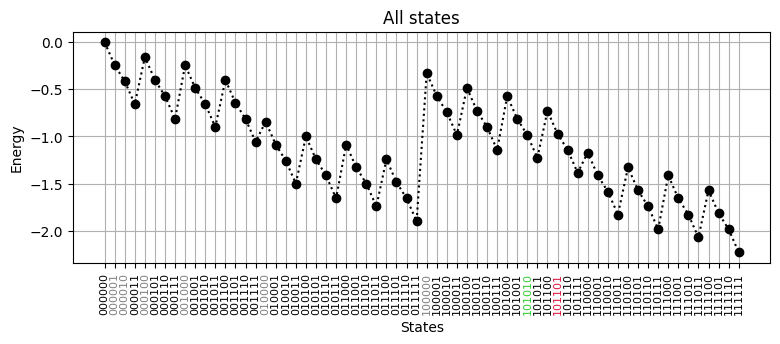

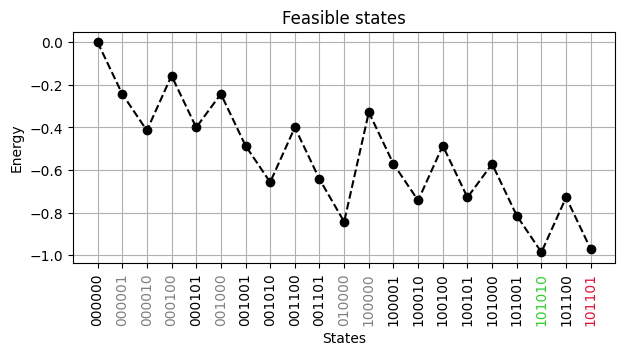

Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {8, 9, 10, 11}
  2: {1, 2, 3, 4, 5, 6, 9, 10, 11, 12}
  3: {1, 3, 5}
  4: {2, 12}
  5: {2, 4, 6, 7, 12}
  6: {4, 6, 7}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
A = 1.1571428571428573
B = 0.04285714285714286
constant = -A + B = -1.1142857142857143

hamiltonian:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII'],
              coeffs=[0.16428571+0.j, 0.42142857+0.j, 0.12142857+0.j, 0.07857143+0.j,
 0.20714286+0.j, 0.12142857+0.j])
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {8, 9, 10, 11}
  2: {1, 2, 3, 4, 5, 6, 9, 10, 11, 12}
  3: {1, 3, 5}
  4: {2, 12}
  5: {2, 4, 6, 7, 12}
  6: {4, 6, 7}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
Mixing circuit created for instance 9 with 6 qubits.
Circuit dimension (QC_DIM): 10
Number of ancillas: 4
Number of control gates: 5
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {8, 9, 10, 11}
  2: {1, 2, 3, 4, 5, 6, 

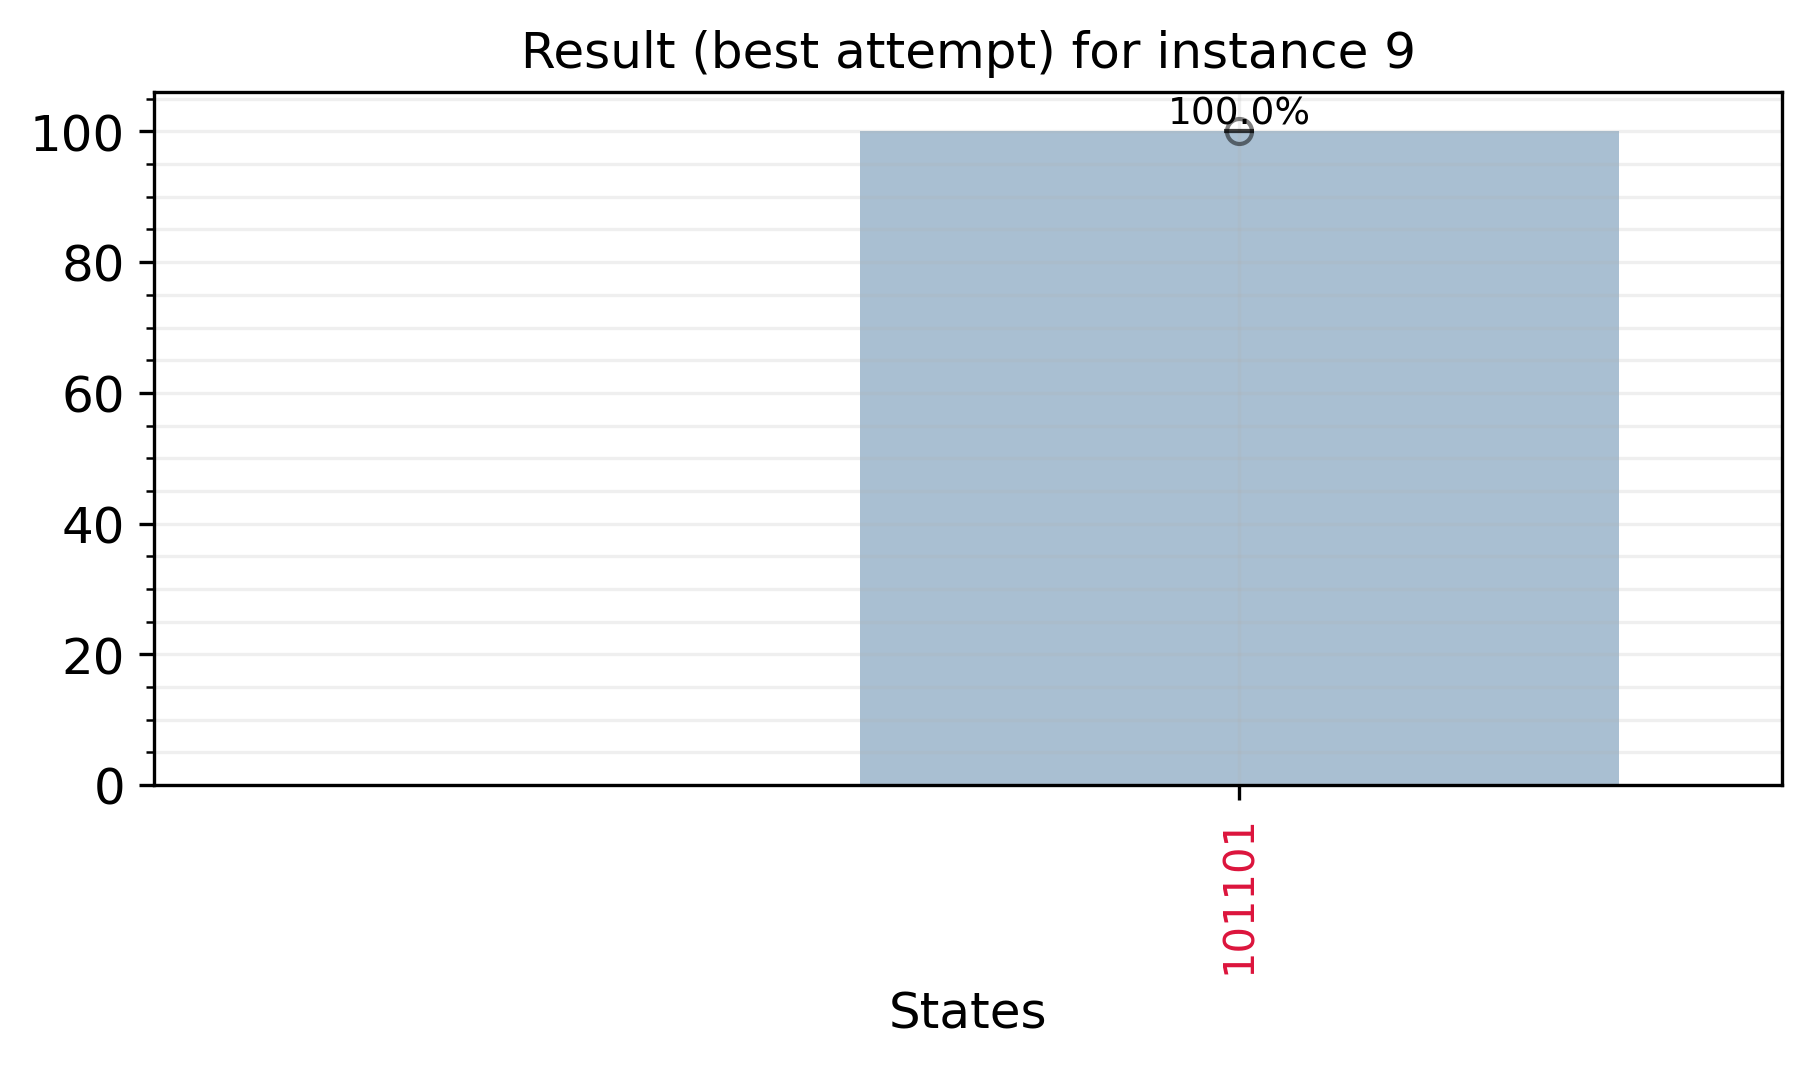

Result saved in:
random_parameters_2025-09-10@08h23m37s/dim6_mail9_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-10@08h23m37s/dim6_mail9_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 23.207229081789652 minutes.
1.0 10
**************************************************
Instance 10 with h = 1.0

U, subsets, EXACT_COVERS, MEC {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} [{1, 2, 4, 6, 7, 8, 9, 10, 11, 12}, {1, 2, 5, 6, 9, 10, 12}, {1, 2, 10}, {3, 4, 7, 8, 11}, {1, 2, 4, 5, 6, 7, 8, 9, 10, 12}, {9, 12, 5, 6}] ['001101', '010100'] ['010100']


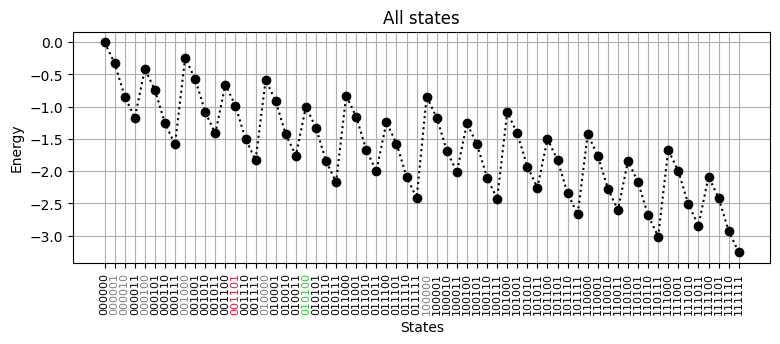

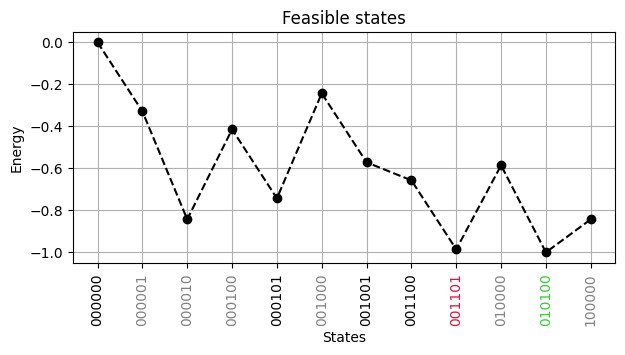

Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {1, 2, 4, 6, 7, 8, 9, 10, 11, 12}
  2: {1, 2, 5, 6, 9, 10, 12}
  3: {1, 2, 10}
  4: {3, 4, 7, 8, 11}
  5: {1, 2, 4, 5, 6, 7, 8, 9, 10, 12}
  6: {9, 12, 5, 6}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
A = 1.6714285714285715
B = 0.04285714285714286
constant = -A + B = -1.6285714285714286

hamiltonian:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII'],
              coeffs=[0.42142857+0.j, 0.29285714+0.j, 0.12142857+0.j, 0.20714286+0.j,
 0.42142857+0.j, 0.16428571+0.j])
Universe: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Subsets:
  1: {1, 2, 4, 6, 7, 8, 9, 10, 11, 12}
  2: {1, 2, 5, 6, 9, 10, 12}
  3: {1, 2, 10}
  4: {3, 4, 7, 8, 11}
  5: {1, 2, 4, 5, 6, 7, 8, 9, 10, 12}
  6: {9, 12, 5, 6}
num_max_ctrl: 5
NUM_ANC: 4
QC_DIM: 10
Mixing circuit created for instance 10 with 6 qubits.
Circuit dimension (QC_DIM): 10
Number of ancillas: 4
Number of control gates: 5
Universe: {1, 2, 3, 4, 5

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8984848895634956
E_min = result.fun = 0.730086539007933

Optimal parameters: betas, gammas = [np.float64(1.5045135829796163), np.float64(6.283185307179586), np.float64(3.2199614126930554e-08), np.float64(4.206632694785868)], [np.float64(6.4679848750377715), np.float64(1.5739021468715104), np.float64(-0.14089258958571763), np.float64(6.4632655081989725)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_4of50
9   010100              370
7   001101              277
10  100000              239
1   000001               44
6   001001               27
4   000101               25
3   000100               22
2   000010                7
5   001000                5
8   010000                5
0   000000                3

---------- 5/50 random_attempts -----------

pars_0 = [2.9474851555481494, 0.5233734144100198, 4.939554201806361, 4.589022893931194, 4.896887008216615, -6.351968603285623, 0.23617496352700584, 3.212962855577522]
bnds = [(0, 6.28318

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9999999999999996
E_min = result.fun = 0.628571428571429

Optimal parameters: betas, gammas = [np.float64(3.1415926257777227), np.float64(6.201924799613775e-08), np.float64(6.283185281339179), np.float64(3.1415926741524127)], [np.float64(-5.563869708484949), np.float64(-6.463542502778832), np.float64(-6.467963928958961), np.float64(6.467984875037494)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_6of50
0  010100             1024

---------- 7/50 random_attempts -----------

pars_0 = [4.247585292597288, 5.993668228711784, 1.285794518524827, 0.037232984277771226, -4.749161599640394, -5.861399869884224, -0.6229836136340712, -4.5807737918117795]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781)]

Optimization terminated successfully.
 

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.949382527620569
E_min = result.fun = 0.6791889009508596

Optimal parameters: betas, gammas = [np.float64(1.0935946551427809), np.float64(0.6083357529423747), np.float64(0.7870564877784325), np.float64(1.3026978226966666)], [np.float64(6.46794353018327), np.float64(-3.3465377931159583), np.float64(0.10078345049926762), np.float64(2.474449063970374)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_22of50
7   001101               594
9   010100               283
3   000101                36
1   000010                29
2   000100                25
10  100000                23
5   001001                11
8   010000                 9
0   000001                 6
4   001000                 6
6   001100                 2

---------- 23/50 random_attempts -----------

pars_0 = [0.1391281075953931, 2.85109980636287, 4.569456613855072, 0.5788695581690317, 0.5123894216519043, 3.326009807115887, -4.735209407870753, -3.106269145325743]
bnds = [(0, 

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9240167145915568
E_min = result.fun = 0.7045547139798718

Optimal parameters: betas, gammas = [np.float64(0.6105239968859045), np.float64(6.283185307160698), np.float64(5.269857186265058), np.float64(4.072106143791202)], [np.float64(5.307219459434171), np.float64(3.0984714413675247), np.float64(-3.098476007965883), np.float64(2.040242500384913e-06)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_31of50
8  010100               594
7  001101               184
9  100000                64
6  001100                61
4  000101                43
5  001001                25
1  000001                24
2  000010                18
0  000000                 7
3  000100                 4

---------- 32/50 random_attempts -----------

pars_0 = [4.570628650144745, 5.282390917952709, 2.956365900737053, 0.8419053250982946, 1.9537287227240983, -4.844677193031456, 3.074497094828602, -5.452429384071175]
bnds = [(0, 6.283185307179586), (0, 6.2831853071795

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.9999999999999958
E_min = result.fun = 0.6285714285714328

Optimal parameters: betas, gammas = [np.float64(3.1415926807144237), np.float64(6.283184914791073), np.float64(3.1415925279819295), np.float64(8.689416063845455e-09)], [np.float64(2.653426135236908), np.float64(0.3415631341451301), np.float64(-0.1704455274028961), np.float64(-6.211509867897719)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_40of50
0  010100              1024

---------- 41/50 random_attempts -----------

pars_0 = [6.092810614732382, 2.7547224554701066, 5.639457287191853, 1.9370828092354673, -3.3396292204505302, 2.309005660155111, -0.17914087302040738, 3.6360334987730996]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781)]

Optimization terminated successfull

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8779263636492484
E_min = result.fun = 0.7506450649221802

Optimal parameters: betas, gammas = [np.float64(4.9424822883115525), np.float64(1.8522580090177208), np.float64(5.781926658066894), np.float64(1.0834959954402346)], [np.float64(6.336066064476306), np.float64(4.414049831565991), np.float64(-1.6124341565870461), np.float64(0.6117371138189457)]
--> ***NOT UPDATING THE BEST ATTEMPT***

    states  counts_p4_43of50
8   001101               278
10  010100               264
11  100000               181
2   000010               124
6   001001                67
7   001100                58
1   000001                14
3   000100                11
5   001000                11
0   000000                 8
9   010000                 7
4   000101                 1

---------- 44/50 random_attempts -----------

pars_0 = [5.551083899051975, 5.869561166758632, 1.3955070792009023, 2.0834268760139834, -0.939400832171664, -1.1592055987303915, -4.269727396673332, 

/tmp/ipython-input-2914445766.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.8566705577326532
E_min = result.fun = 0.7719008708387753

Optimal parameters: betas, gammas = [np.float64(6.283185307179586), np.float64(6.209335650373827), np.float64(2.3550078298441717), np.float64(6.240350889983617)], [np.float64(1.9152731445558393), np.float64(2.8347036103186856), np.float64(2.8150329406771606), np.float64(4.461262945315028)]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_45of50
8  100000               856
7  010100               122
5  001101                17
6  010000                16
4  001100                 8
3  001001                 2
0  000000                 1
1  000001                 1
2  000101                 1

---------- 46/50 random_attempts -----------

pars_0 = [4.715856886278155, 1.3356778484096945, 1.324794239560841, 3.048482146867467, 4.39747544168045, -1.0139711024845166, 2.99007545312005, 2.3512577401859422]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 

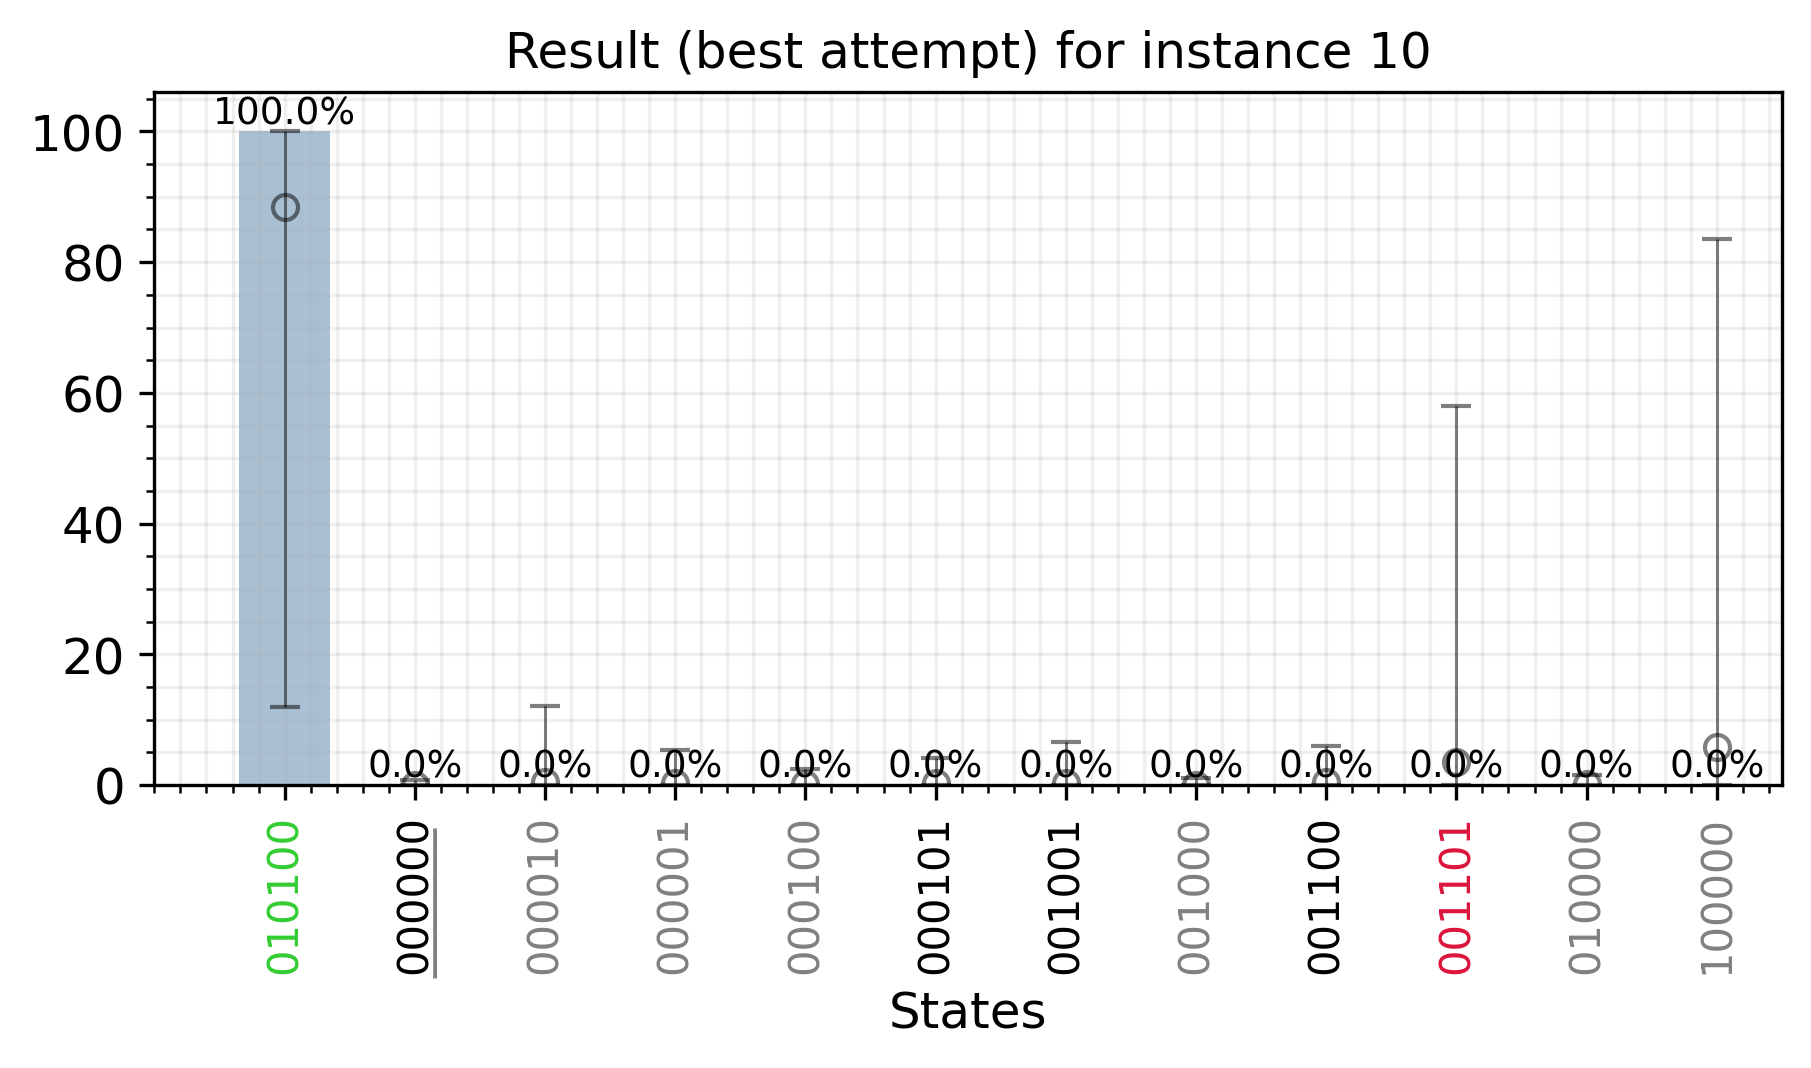

Result saved in:
random_parameters_2025-09-10@08h23m37s/dim6_mail10_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781].csv
random_parameters_2025-09-10@08h23m37s/dim6_mail10_all0_random_p4_50ra_k1.0_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781]_data.txt

TOTAL ELAPSED TIME: 41.35503112872441 minutes.


In [14]:
current_datetime = datetime.now().strftime("%Y-%m-%d@%Hh%Mm%Ss")

# Create a  directory where to collect files
folder_path = f"random_parameters_{current_datetime}"
print(f"Saving in folder_path = {folder_path}")
os.makedirs(folder_path, exist_ok=True)

# Run QAOA+ for every instance.
for h, instance in zip(chosen_ks, chosen_instances):
    print(h, instance)
    print("*"*50)
    print(f"Instance {instance} with h = {h}\n")

    FILENAME_list = [] # list of .csv containing the final histograms data.
    DATA_FILENAME_list = [] # list of .txt containing metadata such as energies, betas, gammas.


    # Define the instance.
    U, subsets_dict = define_instance(n, instance, verbose=False)
    subsets = list(subsets_dict.values())
    _, _, _, _, EXACT_COVERS = find_spectrum(U, subsets_dict, n, h)
    MEC = [state for state in EXACT_COVERS if state.count("1") == min([x.count("1")  for x in EXACT_COVERS])]

    print("U, subsets, EXACT_COVERS, MEC", U, subsets, EXACT_COVERS, MEC)

    # Plot states vs energy.
    show_spectrum(n, instance, h, fontsize=10)


    # Choose the initialization.
    if init_string == 'all1':
        # Only "1"-states.
        init_name = ["".join(elem) for elem in distinct_permutations('0'*(n-1) + '1')]

    elif init_string == 'all0':
        init_name = ["000000"]


    # Prepare the cost and mixing circuit.
    constant, hamiltonian, qc_cost = build_cost_circuit(n, instance, h, verbose=False)
    qc_mixing = build_mixing_circuit(n, instance,verbose=False)
    qc_initial, check_counts  = build_initialization_circuit(n, instance, init_name, verbose=False)

    # # Check that initialization was correct.
    # plot_histogram(check_counts, ax=plt.subplots()[1], title="Initialization check", color='k')
    # plt.show(block=False) # don't stop execution


    # Set initial angles.
    gamma_bound = find_gamma_bound(n, instance, h, verbose=False)

    beta_0 = (0, 2*np.pi)
    gamma_0 =  (-gamma_bound, gamma_bound)
    string_0 = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"

    bnds_beta = (0, 2*np.pi)
    bnds_gamma = (-gamma_bound, gamma_bound)
    bnds_string = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"


    # Build files' names.
    header = f"dim{n}_mail{instance}_{init_string}" \
           + f"_random_p{p}_{random_attempts}ra_k{h}" \
           + f"_BOUNDS{bnds_string}_pars0{string_0}"

    FILENAME = os.path.join(folder_path, header + f".csv")
    DATA_FILENAME = os.path.join(folder_path, header + f"_data.txt")

    FILENAME_list.append(FILENAME)
    DATA_FILENAME_list.append(DATA_FILENAME)


    # Record the details of each attempt in a file.
    with open(DATA_FILENAME, 'a') as DATA_FILE:
        write_params_on_file(DATA_FILE, params) # Write global parameters

        E_best = 100
        TOTAL_start_time = time.time()

        for attempt in range(1,random_attempts+1):
            print(f"\n---------- {attempt}/{random_attempts} random_attempts -----------\n")
            DATA_FILE.write(f"\n---------- {attempt}/{random_attempts} random_attempts -----------\n")

            # Build QAOAAnsatz.
            cost_vs_iteration = [] # to save (and plot) iterations
            ansatz = QAOAAnsatz(qc_cost,
                                mixer_operator=qc_mixing,
                                initial_state=qc_initial,
                                reps=p, name='QAOA+')


            # Generate a pass manager without providing a backend.
            pm = generate_preset_pass_manager(optimization_level=3)
            ansatz_isa = pm.run(ansatz)
            hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

            estimator = StatevectorEstimator()
            sampler = StatevectorSampler()


            # *************************  FIND OPTIMAL ANGLES  ***************************
            # *************************     THROUGH QAOA+     ***************************

            # Set initial angles and angles'bounds.
            pars_0 = [random.uniform(*beta_0) for _ in range(p)] + \
                     [random.uniform(*gamma_0) for _ in range(p)]
            bnds = [bnds_beta]*p + [bnds_gamma]*p

            # print(f"pars_0 = {pars_0}")
            # print(f"bnds = {bnds}\n")


            # Do the minimization.
            result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations
                              pars_0, bounds=bnds,
                              args=(ansatz_isa, hamiltonian_isa, estimator),
                              method="Nelder-Mead",
                              options={"disp": False, "maxiter": 1200, "maxfev": 1200}, tol=1e-4)


            # Works only if you chose cost_func_plot.
            if cost_vs_iteration != []:
                plt.figure()
                plt.plot(cost_vs_iteration)
                plt.xlabel("Iteration")
                plt.ylabel("Cost")
                plt.show()


            # Minimum energy reached with minimization.
            E_min = result.fun + constant
            # print(f"E_min = result.fun + constant = {E_min}")
            # print(f"E_min = result.fun = {result.fun}")
            DATA_FILE.write(f"\nE_min = {E_min}")


            # Optimal parameters (betas, gammas) found.
            betas = list(result.x[:p])
            gammas = list(result.x[p:])
            # print(f"\nOptimal parameters: betas, gammas = {betas}, {gammas}")
            DATA_FILE.write(f'\nE_min\'s parameters: betas = {betas}, gammas = {gammas}\n')


            # Update the best attempt.
            if E_min < E_best:
                    E_best = E_min
                    best_attempt = attempt
                    print("--> ***UPDATING THE BEST ATTEMPT***\n")
            else:
                print("--> ***NOT UPDATING THE BEST ATTEMPT***\n")


            # ****************************  RUN THE CIRCUIT  ******************************
            # ************************ WITH OPTIMAL PARAMETERS ****************************

            # Assign to the previously created ansatz the 2p parameters found.
            pars = betas + gammas
            qc = ansatz.assign_parameters(pars)
            qc.measure_all() # add a measurement

            # Run this circuit.
            qc_isa = pm.run(qc)
            output = sampler.run([qc_isa], shots=1024).result()
            samp_dist = output[0].data.meas.get_counts()


            # ****************************  POST PROCESS  **********************************
            # *********************** AND SAVE THE OUTPUT HISTOGRAM ************************

            # Create a dataframe from the sampling results.
            df = pd.DataFrame(samp_dist.items(), columns=['states', 'counts'])

            # Remove ancillary bits.
            num_ancillas = get_circuit_parameters(subsets, verbose=False)[2]
            df['states'] = df['states'].apply(lambda x: x[num_ancillas:])

            # Invert the bit order for the states (e.g., convert "01101" to "10110").
            df['states'] = df['states'].apply(lambda s: str(s)[::-1])  # Invertiamo l'ordine dei bit

            # After removing the ancillary bits, we aggregate counts by state.
            df = df.groupby(['states']).sum().reset_index()

            # Sort in decreasing order.
            df = df.sort_values('counts', ascending=False)

            # Rename the "counts" column to include attempt details.
            df.columns = ['states', f'counts_p{p}_{attempt}of{random_attempts}']

            # Merge the current attempt dataframe with previously built dataframes.
            if attempt == 1:
                df_all_attempts = df
            else:
                df_all_attempts = pd.merge(df_all_attempts, df, on="states", how="outer")

            print(df)


        # Save to .csv the global dataframe.
        df_all_attempts.to_csv(FILENAME, index=False)


        # Plot the best attempt (minimum energy), with error bars
        # representing other attempts in the global dataframe.
        plot_histogram_of_best_column(df_all_attempts,
                                      f'counts_p{p}_{best_attempt}of{random_attempts}',
                                      EXACT_COVERS, init_name,
                                      fontsize=12, title=f"Result (best attempt) for instance {instance}")


        DATA_FILE.write("\n*******************************")
        DATA_FILE.write(f"\nAttempt that reached the best result with E_min = {E_best} is #{best_attempt} ")
        DATA_FILE.write(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.\n")
        print(f"Result saved in:\n{FILENAME}\n{DATA_FILENAME}")
        print(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.")

## (Optional) Draw the latest instance QAOA circuit

In [ ]:

print(f"Instance #{instance}")
ansatz.decompose(reps=2).draw("mpl")

## Plot from a saved folder ...
### ... for each instance, the best attempt (with also mean and error displayed) or...
Plot the results of all chosen instances for which QAOA has been computed or plot results from a previous run.

The `find_files_containing_string` function will search for `.csv` and `.txt` files in the selected `path`. If provided, it will also search for files that contain a specific string of text.

In [15]:
# Uncomment this line to plot data from an existing directory
# folder_path = "random_parameters_2025-07-21@17h20m50s" # LEC
# folder_path = "random_parameters_2025-07-22@15h10m16s" # LEC-1

# folder_path = "random_parameters_2025-09-08@17h51m29s" # k=1
folder_path = "random_parameters_2025-09-07@11h51m23s" # L_EC

# Find the files that contain every string in 'substrings'.
FILENAME_list, DATA_FILENAME_list = find_files_containing_string(path= f"./{folder_path}/")

# Get the number of files collected.
num_files = len(FILENAME_list)

if num_files>1:
    plot_list_of_files(FILENAME_list, DATA_FILENAME_list,
                       colorchosen="steelblue", alpha=0.6,
                       init_name="all1",
                       dont_show_in_title=["i", "k"],
                       dont_show_in_titles=["n", "p", "ra", "init"],
                       figsize=(8,num_files+1),
                       dpi=200, N=9) # figsize=(10, 13), dpi=300, N=12 for latex figures
else:
    plot_file(FILENAME_list[0], DATA_FILENAME_list[0],
              colorchosen='indigo', alpha=0.4,
              dont_show_in_title = [],
              figsize=(10,4), dpi=200, N=10)

FileNotFoundError: [Errno 2] No such file or directory: './random_parameters_2025-09-07@11h51m23s/'

### ... for each instance, every single attempt

In [ ]:
# folder_path = "random_parameters_2025-01-30@09h03m50s"
plot_each_attempt_from_folder(folder_path)

In [ ]:
print(info_dim6)
